In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import copy

env = gym.make('CartPole-v1')
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

EPISODES = 500
EPISODES_TEST = int(EPISODES/2)
LEARNING_RATE = 0.0001
MEM_SIZE = 10000
BATCH_SIZE = 32
GAMMA = 0.95
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.999
EXPLORATION_MIN = 0.001
epsilons_attacks = [0,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,0.15,0.18,0.22]


FC1_DIMS = 1024
FC2_DIMS = 512
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [56]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space

        self.fc1 = nn.Linear(*self.input_shape, FC1_DIMS)
        self.fc2 = nn.Linear(FC1_DIMS, FC2_DIMS)
        self.fc3 = nn.Linear(FC2_DIMS, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.MSELoss()
        self.to(DEVICE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0

        self.states = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=np.bool)

    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE

        self.states[mem_index]  = state.clone().detach().numpy()
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_.clone().detach().numpy()
        self.dones[mem_index] =  1 - done

        self.mem_count += 1

    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)

        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]

        return states, actions, rewards, states_, dones

class DQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.exploration_rate = EXPLORATION_MAX
        self.network = Network()
        self.target_network = copy.deepcopy(self.network)

    def choose_action(self, observation, eps_greedy=True):
        if eps_greedy and random.random() < self.exploration_rate:
            return env.action_space.sample(), 0.0

        state = observation
        state = state.to(DEVICE)
        state = state.unsqueeze(0)

        q_values = self.network(state)
        return torch.argmax(q_values).item(), q_values

    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return

        states, actions, rewards, states_, dones = self.memory.sample()
        states = torch.tensor(states , dtype=torch.float32).to(DEVICE)
        actions = torch.tensor(actions, dtype=torch.long).to(DEVICE)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
        states_ = torch.tensor(states_, dtype=torch.float32).to(DEVICE)
        dones = torch.tensor(dones, dtype=torch.bool).to(DEVICE)

        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)
        states.requires_grad = True
        
        q_values = self.network(states)
        next_q_values = self.network(states_)
        target_next_q_values = self.target_network(states_)

        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = target_next_q_values[:, torch.argmax(next_q_values, dim=1)[0]].detach()
        q_target = rewards + GAMMA * predicted_value_of_future * dones

        loss = self.network.loss(q_target, predicted_value_of_now)        
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)
        
        TAU = 5e-3
        for target_param, q_param in zip(self.target_network.parameters(), self.network.parameters()):
            target_param.data.copy_(TAU * q_param.data + (1.0 - TAU) * target_param.data)
        
    def returning_epsilon(self):
        return self.exploration_rate


## Training the network (only run if wanting to train again)

In [ ]:
agent_clean = DQN_Solver()
agent_clean.network.train()

best_reward = 0
average_reward = 0

print ("{:<6} {:<20} {:<8} {:<8} {:<8}".format("Episode", "Average Reward", "Best Reward", "Last Reward", "Epsilon"))

for i in range(1, EPISODES):
    state = env.reset()
    score = 0
    while True:
        action, q_values = agent_clean.choose_action(state)        
        state_, reward, done, info = env.step(action)
        agent_clean.memory.add(state, action, reward, state_, done)
        agent_clean.learn()
        state = state_
        score += reward
        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score         
            print ("{:<6} {:<20} {:<8} {:<8} {:<8}".format(i, average_reward / i, best_reward, score, agent_clean.returning_epsilon()))
            break



In [58]:
#Saving the model 
#ONLY RUN WHEN TRAINED AGAIN
torch.save(agent_clean, "trained_DDQN_500_000_1.pth")

## Testing the network

In [70]:
def attack_FGSM(state, epsilon, agent):
    if epsilon < 0.01:
        return state
    state.requires_grad_()
    q_values = agent.target_network(state.to(DEVICE))
    index_worst_case = torch.argmin(q_values)
    loss_softmax = -torch.log(torch.softmax(q_values,0)[index_worst_case])
    gradient_sign = torch.autograd.grad(loss_softmax,state,retain_graph=True)[0].sign()
    pert_state = state - gradient_sign * epsilon
    return pert_state.detach()

def train_attack_FGSM(state, epsilon, agent):
    state.requires_grad_()
    q_values = agent.network(state.to(DEVICE))
    index_worst_case = torch.argmin(q_values)
    
    q_values = agent.target_network(state.to(DEVICE))
    loss_softmax = -torch.log(torch.softmax(q_values,0)[index_worst_case])
    gradient_sign = torch.autograd.grad(loss_softmax,state,retain_graph=True)[0].sign()
    pert_state = state - gradient_sign * epsilon
    return pert_state.detach()

In [73]:
def test_network(agent, epsilon):
    agent.network.eval()
    
    best_reward = 0
    
    average_reward_attacked = 0
    print("NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS:", epsilon)
    print ("{:<6} {:<20} {:<8} {:<8} {:<8}".format("Episode", "Average Reward", "Best Reward", "Last Reward", "Epsilon exploring" , "Epsilon attack"))
    env._max_episode_steps = 1000
    for i in range(1,EPISODES_TEST):
        state = env.reset()
        score = 0
        
        while True:
            pert_state = attack_FGSM(state, epsilon, agent)

            action, q_values = agent.choose_action(pert_state,eps_greedy= False)
            state_, reward, done, info = env.step(action)

            state = state_.detach()
            score += reward
            if done:            
                if score > best_reward:
                    best_reward = score
                average_reward_attacked += score
                print ("{:<6} {:<20} {:<8} {:<8} {:<8} {:<8}".format(i, average_reward_attacked/i, best_reward, score, agent.returning_epsilon(),epsilon))
                break
                
    return average_reward_attacked / i
    

In [ ]:
average_reward_number_attacked = []
agent_clean = torch.load("trained_DDQN_500_000_1.pth")
for epsilon in epsilons_attacks:
    clean_result = test_network(agent_clean, epsilon)
    average_reward_number_attacked.append(clean_result)
    print(epsilon , '  ',clean_result)

# Plotting

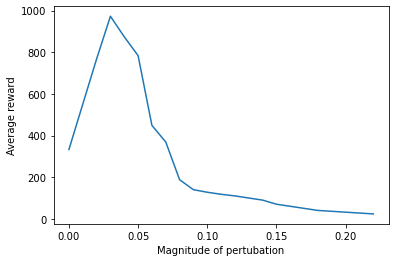

In [75]:
plt.figure(1)
new_rewards = []

for reward in average_reward_number_attacked:
    new_rewards.append(reward)
    
plt.plot(epsilons_attacks,new_rewards)
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.show()

## Training with adversarial training (only run if you want to train again)

In [76]:
def train_robust(agent_robust, EPSILON_PERT):
    agent_robust.network.train()

    best_reward = 0
    average_reward = 0
    
    for i in range(1, EPISODES):
        epsilon_pertubated = EPSILON_PERT/(EPISODES - i)
        state = env.reset()
        score = 0
        while True:
            pert_state = train_attack_FGSM(state, epsilon_pertubated, agent_robust)
            action, q_values = agent_robust.choose_action(pert_state)
            state_, reward, done, info = env.step(action)
            agent_robust.memory.add(state, action, reward, state_, done)
            agent_robust.learn()
            state = state_
            score += reward
            if done:
                if score > best_reward:
                    best_reward = score
                average_reward += score
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
                break


In [ ]:
robust_agent_1 = DQN_Solver()
robust_agent_2 = DQN_Solver()
robust_agent_3 = DQN_Solver()
robust_agent_4 = DQN_Solver()
agents = [[robust_agent_1,0.02],[robust_agent_2, 0.05], [robust_agent_3, 0.08], [robust_agent_4, 0.1]]
for agent, eps in agents:
    print("NOW TRAINING AGENT WITH EPS:", eps)
    train_robust(agent, eps)

In [ ]:
torch.save(robust_agent_1, "trained_DDQN_500_002_1.pth")
torch.save(robust_agent_2, "trained_DDQN_500_005_1.pth")
torch.save(robust_agent_3, "trained_DDQN_500_008_1.pth")
torch.save(robust_agent_4, "trained_DDQN_500_010_1.pth")

## Testing robust network

In [12]:
robust_agent_1 = torch.load("trained_DDQN_500_002.pth")
robust_agent_2 = torch.load("trained_DDQN_500_005.pth")
robust_agent_3 = torch.load("trained_DDQN_500_008.pth")
robust_agent_4 = torch.load("trained_DDQN_500_010.pth")


In [16]:
robust_agents = [robust_agent_1, robust_agent_2,robust_agent_3,robust_agent_4]
robust_average_rewards = []
for agent in robust_agents:
    print("The current agent is", agent)
    robust_average_reward = []
    for epsilon in epsilons_attacks:
        average_rewards = test_network(agent, epsilon)
        robust_average_reward.append(average_rewards)
        print(epsilon , '  ',average_rewards)
    robust_average_rewards.append(robust_average_reward)

The current agent is <__main__.DQN_Solver object at 0x7fa5c8dcf550>
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0
Episode Average Reward       Best Reward Last Reward Epsilon exploring
1      500.0                500.0    500.0    0.001    0       
2      500.0                500.0    500.0    0.001    0       
3      500.0                500.0    500.0    0.001    0       
4      500.0                500.0    500.0    0.001    0       
5      500.0                500.0    500.0    0.001    0       
6      500.0                500.0    500.0    0.001    0       
7      500.0                500.0    500.0    0.001    0       
8      500.0                500.0    500.0    0.001    0       
9      500.0                500.0    500.0    0.001    0       
10     500.0                500.0    500.0    0.001    0       
11     500.0                500.0    500.0    0.001    0       
12     500.0                500.0    500.0    0.001    0       
13     500.0                500.0    500.0    

127    500.0                500.0    500.0    0.001    0       
128    500.0                500.0    500.0    0.001    0       
129    500.0                500.0    500.0    0.001    0       
130    500.0                500.0    500.0    0.001    0       
131    500.0                500.0    500.0    0.001    0       
132    500.0                500.0    500.0    0.001    0       
133    500.0                500.0    500.0    0.001    0       
134    500.0                500.0    500.0    0.001    0       
135    500.0                500.0    500.0    0.001    0       
136    500.0                500.0    500.0    0.001    0       
137    500.0                500.0    500.0    0.001    0       
138    500.0                500.0    500.0    0.001    0       
139    500.0                500.0    500.0    0.001    0       
140    500.0                500.0    500.0    0.001    0       
141    500.0                500.0    500.0    0.001    0       
142    500.0                500.0    500

4      500.0                500.0    500.0    0.001    0.02    
5      500.0                500.0    500.0    0.001    0.02    
6      500.0                500.0    500.0    0.001    0.02    
7      500.0                500.0    500.0    0.001    0.02    
8      500.0                500.0    500.0    0.001    0.02    
9      500.0                500.0    500.0    0.001    0.02    
10     500.0                500.0    500.0    0.001    0.02    
11     500.0                500.0    500.0    0.001    0.02    
12     500.0                500.0    500.0    0.001    0.02    
13     500.0                500.0    500.0    0.001    0.02    
14     500.0                500.0    500.0    0.001    0.02    
15     500.0                500.0    500.0    0.001    0.02    
16     500.0                500.0    500.0    0.001    0.02    
17     500.0                500.0    500.0    0.001    0.02    
18     500.0                500.0    500.0    0.001    0.02    
19     500.0                500.0    500

133    500.0                500.0    500.0    0.001    0.02    
134    500.0                500.0    500.0    0.001    0.02    
135    500.0                500.0    500.0    0.001    0.02    
136    500.0                500.0    500.0    0.001    0.02    
137    500.0                500.0    500.0    0.001    0.02    
138    500.0                500.0    500.0    0.001    0.02    
139    500.0                500.0    500.0    0.001    0.02    
140    500.0                500.0    500.0    0.001    0.02    
141    500.0                500.0    500.0    0.001    0.02    
142    500.0                500.0    500.0    0.001    0.02    
143    500.0                500.0    500.0    0.001    0.02    
144    500.0                500.0    500.0    0.001    0.02    
145    500.0                500.0    500.0    0.001    0.02    
146    500.0                500.0    500.0    0.001    0.02    
147    500.0                500.0    500.0    0.001    0.02    
148    500.0                500.0    500

10     500.0                500.0    500.0    0.001    0.03    
11     500.0                500.0    500.0    0.001    0.03    
12     500.0                500.0    500.0    0.001    0.03    
13     500.0                500.0    500.0    0.001    0.03    
14     500.0                500.0    500.0    0.001    0.03    
15     500.0                500.0    500.0    0.001    0.03    
16     500.0                500.0    500.0    0.001    0.03    
17     500.0                500.0    500.0    0.001    0.03    
18     500.0                500.0    500.0    0.001    0.03    
19     500.0                500.0    500.0    0.001    0.03    
20     500.0                500.0    500.0    0.001    0.03    
21     500.0                500.0    500.0    0.001    0.03    
22     500.0                500.0    500.0    0.001    0.03    
23     500.0                500.0    500.0    0.001    0.03    
24     500.0                500.0    500.0    0.001    0.03    
25     500.0                500.0    500

139    500.0                500.0    500.0    0.001    0.03    
140    500.0                500.0    500.0    0.001    0.03    
141    500.0                500.0    500.0    0.001    0.03    
142    500.0                500.0    500.0    0.001    0.03    
143    500.0                500.0    500.0    0.001    0.03    
144    500.0                500.0    500.0    0.001    0.03    
145    500.0                500.0    500.0    0.001    0.03    
146    500.0                500.0    500.0    0.001    0.03    
147    500.0                500.0    500.0    0.001    0.03    
148    500.0                500.0    500.0    0.001    0.03    
149    500.0                500.0    500.0    0.001    0.03    
150    500.0                500.0    500.0    0.001    0.03    
151    500.0                500.0    500.0    0.001    0.03    
152    500.0                500.0    500.0    0.001    0.03    
153    500.0                500.0    500.0    0.001    0.03    
154    500.0                500.0    500

16     340.5                500.0    252.0    0.001    0.04    
17     336.2352941176471    500.0    268.0    0.001    0.04    
18     328.3333333333333    500.0    194.0    0.001    0.04    
19     326.94736842105266   500.0    302.0    0.001    0.04    
20     324.75               500.0    283.0    0.001    0.04    
21     327.6190476190476    500.0    385.0    0.001    0.04    
22     328.0                500.0    336.0    0.001    0.04    
23     325.30434782608694   500.0    266.0    0.001    0.04    
24     323.75               500.0    288.0    0.001    0.04    
25     327.16               500.0    409.0    0.001    0.04    
26     322.2307692307692    500.0    199.0    0.001    0.04    
27     320.55555555555554   500.0    277.0    0.001    0.04    
28     318.89285714285717   500.0    274.0    0.001    0.04    
29     325.13793103448273   500.0    500.0    0.001    0.04    
30     322.9                500.0    258.0    0.001    0.04    
31     319.5483870967742    500.0    219

145    316.51724137931035   500.0    405.0    0.001    0.04    
146    316.1849315068493    500.0    268.0    0.001    0.04    
147    316.89115646258506   500.0    420.0    0.001    0.04    
148    317.6081081081081    500.0    423.0    0.001    0.04    
149    318.30872483221475   500.0    422.0    0.001    0.04    
150    317.26               500.0    161.0    0.001    0.04    
151    317.81456953642385   500.0    401.0    0.001    0.04    
152    317.4078947368421    500.0    256.0    0.001    0.04    
153    317.05882352941177   500.0    264.0    0.001    0.04    
154    318.0584415584416    500.0    471.0    0.001    0.04    
155    318.2                500.0    340.0    0.001    0.04    
156    318.4935897435897    500.0    364.0    0.001    0.04    
157    318.8980891719745    500.0    382.0    0.001    0.04    
158    318.54430379746833   500.0    263.0    0.001    0.04    
159    318.9622641509434    500.0    385.0    0.001    0.04    
160    320.09375            500.0    500

22     467.0                500.0    500.0    0.001    0.05    
23     468.4347826086956    500.0    500.0    0.001    0.05    
24     469.75               500.0    500.0    0.001    0.05    
25     470.96               500.0    500.0    0.001    0.05    
26     472.0769230769231    500.0    500.0    0.001    0.05    
27     473.1111111111111    500.0    500.0    0.001    0.05    
28     474.07142857142856   500.0    500.0    0.001    0.05    
29     474.9655172413793    500.0    500.0    0.001    0.05    
30     475.8                500.0    500.0    0.001    0.05    
31     476.5806451612903    500.0    500.0    0.001    0.05    
32     477.3125             500.0    500.0    0.001    0.05    
33     478.0                500.0    500.0    0.001    0.05    
34     478.6470588235294    500.0    500.0    0.001    0.05    
35     479.25714285714287   500.0    500.0    0.001    0.05    
36     479.8333333333333    500.0    500.0    0.001    0.05    
37     480.3783783783784    500.0    500

151    483.9337748344371    500.0    500.0    0.001    0.05    
152    482.5921052631579    500.0    280.0    0.001    0.05    
153    482.70588235294116   500.0    500.0    0.001    0.05    
154    482.8181818181818    500.0    500.0    0.001    0.05    
155    482.9290322580645    500.0    500.0    0.001    0.05    
156    483.03846153846155   500.0    500.0    0.001    0.05    
157    482.1656050955414    500.0    346.0    0.001    0.05    
158    482.27848101265823   500.0    500.0    0.001    0.05    
159    482.38993710691824   500.0    500.0    0.001    0.05    
160    482.5                500.0    500.0    0.001    0.05    
161    482.60869565217394   500.0    500.0    0.001    0.05    
162    482.71604938271605   500.0    500.0    0.001    0.05    
163    482.82208588957053   500.0    500.0    0.001    0.05    
164    482.9268292682927    500.0    500.0    0.001    0.05    
165    483.030303030303     500.0    500.0    0.001    0.05    
166    483.13253012048193   500.0    500

28     500.0                500.0    500.0    0.001    0.06    
29     500.0                500.0    500.0    0.001    0.06    
30     500.0                500.0    500.0    0.001    0.06    
31     500.0                500.0    500.0    0.001    0.06    
32     500.0                500.0    500.0    0.001    0.06    
33     500.0                500.0    500.0    0.001    0.06    
34     500.0                500.0    500.0    0.001    0.06    
35     500.0                500.0    500.0    0.001    0.06    
36     500.0                500.0    500.0    0.001    0.06    
37     500.0                500.0    500.0    0.001    0.06    
38     500.0                500.0    500.0    0.001    0.06    
39     500.0                500.0    500.0    0.001    0.06    
40     500.0                500.0    500.0    0.001    0.06    
41     500.0                500.0    500.0    0.001    0.06    
42     500.0                500.0    500.0    0.001    0.06    
43     500.0                500.0    500

157    500.0                500.0    500.0    0.001    0.06    
158    500.0                500.0    500.0    0.001    0.06    
159    500.0                500.0    500.0    0.001    0.06    
160    500.0                500.0    500.0    0.001    0.06    
161    500.0                500.0    500.0    0.001    0.06    
162    500.0                500.0    500.0    0.001    0.06    
163    500.0                500.0    500.0    0.001    0.06    
164    500.0                500.0    500.0    0.001    0.06    
165    500.0                500.0    500.0    0.001    0.06    
166    500.0                500.0    500.0    0.001    0.06    
167    500.0                500.0    500.0    0.001    0.06    
168    500.0                500.0    500.0    0.001    0.06    
169    500.0                500.0    500.0    0.001    0.06    
170    500.0                500.0    500.0    0.001    0.06    
171    500.0                500.0    500.0    0.001    0.06    
172    500.0                500.0    500

34     500.0                500.0    500.0    0.001    0.07    
35     500.0                500.0    500.0    0.001    0.07    
36     500.0                500.0    500.0    0.001    0.07    
37     500.0                500.0    500.0    0.001    0.07    
38     500.0                500.0    500.0    0.001    0.07    
39     500.0                500.0    500.0    0.001    0.07    
40     500.0                500.0    500.0    0.001    0.07    
41     500.0                500.0    500.0    0.001    0.07    
42     500.0                500.0    500.0    0.001    0.07    
43     500.0                500.0    500.0    0.001    0.07    
44     500.0                500.0    500.0    0.001    0.07    
45     500.0                500.0    500.0    0.001    0.07    
46     500.0                500.0    500.0    0.001    0.07    
47     500.0                500.0    500.0    0.001    0.07    
48     500.0                500.0    500.0    0.001    0.07    
49     500.0                500.0    500

163    500.0                500.0    500.0    0.001    0.07    
164    500.0                500.0    500.0    0.001    0.07    
165    500.0                500.0    500.0    0.001    0.07    
166    500.0                500.0    500.0    0.001    0.07    
167    500.0                500.0    500.0    0.001    0.07    
168    500.0                500.0    500.0    0.001    0.07    
169    500.0                500.0    500.0    0.001    0.07    
170    500.0                500.0    500.0    0.001    0.07    
171    500.0                500.0    500.0    0.001    0.07    
172    500.0                500.0    500.0    0.001    0.07    
173    500.0                500.0    500.0    0.001    0.07    
174    500.0                500.0    500.0    0.001    0.07    
175    500.0                500.0    500.0    0.001    0.07    
176    500.0                500.0    500.0    0.001    0.07    
177    500.0                500.0    500.0    0.001    0.07    
178    500.0                500.0    500

40     500.0                500.0    500.0    0.001    0.08    
41     500.0                500.0    500.0    0.001    0.08    
42     500.0                500.0    500.0    0.001    0.08    
43     500.0                500.0    500.0    0.001    0.08    
44     500.0                500.0    500.0    0.001    0.08    
45     500.0                500.0    500.0    0.001    0.08    
46     500.0                500.0    500.0    0.001    0.08    
47     500.0                500.0    500.0    0.001    0.08    
48     500.0                500.0    500.0    0.001    0.08    
49     500.0                500.0    500.0    0.001    0.08    
50     500.0                500.0    500.0    0.001    0.08    
51     500.0                500.0    500.0    0.001    0.08    
52     500.0                500.0    500.0    0.001    0.08    
53     500.0                500.0    500.0    0.001    0.08    
54     500.0                500.0    500.0    0.001    0.08    
55     500.0                500.0    500

169    500.0                500.0    500.0    0.001    0.08    
170    500.0                500.0    500.0    0.001    0.08    
171    500.0                500.0    500.0    0.001    0.08    
172    500.0                500.0    500.0    0.001    0.08    
173    500.0                500.0    500.0    0.001    0.08    
174    500.0                500.0    500.0    0.001    0.08    
175    500.0                500.0    500.0    0.001    0.08    
176    500.0                500.0    500.0    0.001    0.08    
177    500.0                500.0    500.0    0.001    0.08    
178    500.0                500.0    500.0    0.001    0.08    
179    500.0                500.0    500.0    0.001    0.08    
180    500.0                500.0    500.0    0.001    0.08    
181    500.0                500.0    500.0    0.001    0.08    
182    500.0                500.0    500.0    0.001    0.08    
183    500.0                500.0    500.0    0.001    0.08    
184    500.0                500.0    500

46     500.0                500.0    500.0    0.001    0.09    
47     500.0                500.0    500.0    0.001    0.09    
48     500.0                500.0    500.0    0.001    0.09    
49     500.0                500.0    500.0    0.001    0.09    
50     500.0                500.0    500.0    0.001    0.09    
51     500.0                500.0    500.0    0.001    0.09    
52     500.0                500.0    500.0    0.001    0.09    
53     500.0                500.0    500.0    0.001    0.09    
54     500.0                500.0    500.0    0.001    0.09    
55     500.0                500.0    500.0    0.001    0.09    
56     500.0                500.0    500.0    0.001    0.09    
57     500.0                500.0    500.0    0.001    0.09    
58     500.0                500.0    500.0    0.001    0.09    
59     500.0                500.0    500.0    0.001    0.09    
60     500.0                500.0    500.0    0.001    0.09    
61     500.0                500.0    500

175    500.0                500.0    500.0    0.001    0.09    
176    500.0                500.0    500.0    0.001    0.09    
177    500.0                500.0    500.0    0.001    0.09    
178    500.0                500.0    500.0    0.001    0.09    
179    500.0                500.0    500.0    0.001    0.09    
180    500.0                500.0    500.0    0.001    0.09    
181    500.0                500.0    500.0    0.001    0.09    
182    500.0                500.0    500.0    0.001    0.09    
183    500.0                500.0    500.0    0.001    0.09    
184    500.0                500.0    500.0    0.001    0.09    
185    500.0                500.0    500.0    0.001    0.09    
186    500.0                500.0    500.0    0.001    0.09    
187    500.0                500.0    500.0    0.001    0.09    
188    500.0                500.0    500.0    0.001    0.09    
189    500.0                500.0    500.0    0.001    0.09    
190    500.0                500.0    500

52     500.0                500.0    500.0    0.001    0.1     
53     500.0                500.0    500.0    0.001    0.1     
54     500.0                500.0    500.0    0.001    0.1     
55     500.0                500.0    500.0    0.001    0.1     
56     500.0                500.0    500.0    0.001    0.1     
57     500.0                500.0    500.0    0.001    0.1     
58     500.0                500.0    500.0    0.001    0.1     
59     500.0                500.0    500.0    0.001    0.1     
60     500.0                500.0    500.0    0.001    0.1     
61     500.0                500.0    500.0    0.001    0.1     
62     500.0                500.0    500.0    0.001    0.1     
63     500.0                500.0    500.0    0.001    0.1     
64     500.0                500.0    500.0    0.001    0.1     
65     500.0                500.0    500.0    0.001    0.1     
66     500.0                500.0    500.0    0.001    0.1     
67     500.0                500.0    500

181    497.7900552486188    500.0    500.0    0.001    0.1     
182    497.8021978021978    500.0    500.0    0.001    0.1     
183    497.8142076502732    500.0    500.0    0.001    0.1     
184    497.82608695652175   500.0    500.0    0.001    0.1     
185    497.8378378378378    500.0    500.0    0.001    0.1     
186    497.8494623655914    500.0    500.0    0.001    0.1     
187    497.86096256684493   500.0    500.0    0.001    0.1     
188    497.8723404255319    500.0    500.0    0.001    0.1     
189    497.8835978835979    500.0    500.0    0.001    0.1     
190    497.89473684210526   500.0    500.0    0.001    0.1     
191    497.90575916230364   500.0    500.0    0.001    0.1     
192    497.9166666666667    500.0    500.0    0.001    0.1     
193    497.92746113989637   500.0    500.0    0.001    0.1     
194    497.9381443298969    500.0    500.0    0.001    0.1     
195    497.94871794871796   500.0    500.0    0.001    0.1     
196    497.9591836734694    500.0    500

58     500.0                500.0    500.0    0.001    0.11    
59     500.0                500.0    500.0    0.001    0.11    
60     500.0                500.0    500.0    0.001    0.11    
61     500.0                500.0    500.0    0.001    0.11    
62     500.0                500.0    500.0    0.001    0.11    
63     500.0                500.0    500.0    0.001    0.11    
64     500.0                500.0    500.0    0.001    0.11    
65     500.0                500.0    500.0    0.001    0.11    
66     500.0                500.0    500.0    0.001    0.11    
67     500.0                500.0    500.0    0.001    0.11    
68     500.0                500.0    500.0    0.001    0.11    
69     500.0                500.0    500.0    0.001    0.11    
70     500.0                500.0    500.0    0.001    0.11    
71     500.0                500.0    500.0    0.001    0.11    
72     500.0                500.0    500.0    0.001    0.11    
73     500.0                500.0    500

187    500.0                500.0    500.0    0.001    0.11    
188    500.0                500.0    500.0    0.001    0.11    
189    500.0                500.0    500.0    0.001    0.11    
190    500.0                500.0    500.0    0.001    0.11    
191    500.0                500.0    500.0    0.001    0.11    
192    500.0                500.0    500.0    0.001    0.11    
193    500.0                500.0    500.0    0.001    0.11    
194    500.0                500.0    500.0    0.001    0.11    
195    500.0                500.0    500.0    0.001    0.11    
196    500.0                500.0    500.0    0.001    0.11    
197    500.0                500.0    500.0    0.001    0.11    
198    500.0                500.0    500.0    0.001    0.11    
199    500.0                500.0    500.0    0.001    0.11    
200    500.0                500.0    500.0    0.001    0.11    
201    500.0                500.0    500.0    0.001    0.11    
202    500.0                500.0    500

64     500.0                500.0    500.0    0.001    0.12    
65     500.0                500.0    500.0    0.001    0.12    
66     500.0                500.0    500.0    0.001    0.12    
67     500.0                500.0    500.0    0.001    0.12    
68     500.0                500.0    500.0    0.001    0.12    
69     500.0                500.0    500.0    0.001    0.12    
70     500.0                500.0    500.0    0.001    0.12    
71     500.0                500.0    500.0    0.001    0.12    
72     500.0                500.0    500.0    0.001    0.12    
73     500.0                500.0    500.0    0.001    0.12    
74     500.0                500.0    500.0    0.001    0.12    
75     500.0                500.0    500.0    0.001    0.12    
76     500.0                500.0    500.0    0.001    0.12    
77     500.0                500.0    500.0    0.001    0.12    
78     500.0                500.0    500.0    0.001    0.12    
79     500.0                500.0    500

193    500.0                500.0    500.0    0.001    0.12    
194    500.0                500.0    500.0    0.001    0.12    
195    500.0                500.0    500.0    0.001    0.12    
196    500.0                500.0    500.0    0.001    0.12    
197    500.0                500.0    500.0    0.001    0.12    
198    500.0                500.0    500.0    0.001    0.12    
199    500.0                500.0    500.0    0.001    0.12    
200    500.0                500.0    500.0    0.001    0.12    
201    500.0                500.0    500.0    0.001    0.12    
202    500.0                500.0    500.0    0.001    0.12    
203    500.0                500.0    500.0    0.001    0.12    
204    500.0                500.0    500.0    0.001    0.12    
205    500.0                500.0    500.0    0.001    0.12    
206    500.0                500.0    500.0    0.001    0.12    
207    500.0                500.0    500.0    0.001    0.12    
208    500.0                500.0    500

70     500.0                500.0    500.0    0.001    0.13    
71     500.0                500.0    500.0    0.001    0.13    
72     500.0                500.0    500.0    0.001    0.13    
73     500.0                500.0    500.0    0.001    0.13    
74     500.0                500.0    500.0    0.001    0.13    
75     500.0                500.0    500.0    0.001    0.13    
76     500.0                500.0    500.0    0.001    0.13    
77     500.0                500.0    500.0    0.001    0.13    
78     500.0                500.0    500.0    0.001    0.13    
79     500.0                500.0    500.0    0.001    0.13    
80     500.0                500.0    500.0    0.001    0.13    
81     500.0                500.0    500.0    0.001    0.13    
82     500.0                500.0    500.0    0.001    0.13    
83     500.0                500.0    500.0    0.001    0.13    
84     500.0                500.0    500.0    0.001    0.13    
85     500.0                500.0    500

199    500.0                500.0    500.0    0.001    0.13    
200    500.0                500.0    500.0    0.001    0.13    
201    500.0                500.0    500.0    0.001    0.13    
202    500.0                500.0    500.0    0.001    0.13    
203    500.0                500.0    500.0    0.001    0.13    
204    500.0                500.0    500.0    0.001    0.13    
205    500.0                500.0    500.0    0.001    0.13    
206    500.0                500.0    500.0    0.001    0.13    
207    500.0                500.0    500.0    0.001    0.13    
208    500.0                500.0    500.0    0.001    0.13    
209    500.0                500.0    500.0    0.001    0.13    
210    500.0                500.0    500.0    0.001    0.13    
211    500.0                500.0    500.0    0.001    0.13    
212    500.0                500.0    500.0    0.001    0.13    
213    500.0                500.0    500.0    0.001    0.13    
214    500.0                500.0    500

76     500.0                500.0    500.0    0.001    0.14    
77     500.0                500.0    500.0    0.001    0.14    
78     500.0                500.0    500.0    0.001    0.14    
79     500.0                500.0    500.0    0.001    0.14    
80     500.0                500.0    500.0    0.001    0.14    
81     500.0                500.0    500.0    0.001    0.14    
82     500.0                500.0    500.0    0.001    0.14    
83     500.0                500.0    500.0    0.001    0.14    
84     500.0                500.0    500.0    0.001    0.14    
85     500.0                500.0    500.0    0.001    0.14    
86     500.0                500.0    500.0    0.001    0.14    
87     500.0                500.0    500.0    0.001    0.14    
88     500.0                500.0    500.0    0.001    0.14    
89     500.0                500.0    500.0    0.001    0.14    
90     500.0                500.0    500.0    0.001    0.14    
91     500.0                500.0    500

205    500.0                500.0    500.0    0.001    0.14    
206    500.0                500.0    500.0    0.001    0.14    
207    500.0                500.0    500.0    0.001    0.14    
208    500.0                500.0    500.0    0.001    0.14    
209    500.0                500.0    500.0    0.001    0.14    
210    500.0                500.0    500.0    0.001    0.14    
211    500.0                500.0    500.0    0.001    0.14    
212    500.0                500.0    500.0    0.001    0.14    
213    500.0                500.0    500.0    0.001    0.14    
214    500.0                500.0    500.0    0.001    0.14    
215    500.0                500.0    500.0    0.001    0.14    
216    500.0                500.0    500.0    0.001    0.14    
217    500.0                500.0    500.0    0.001    0.14    
218    500.0                500.0    500.0    0.001    0.14    
219    500.0                500.0    500.0    0.001    0.14    
220    500.0                500.0    500

82     500.0                500.0    500.0    0.001    0.15    
83     500.0                500.0    500.0    0.001    0.15    
84     500.0                500.0    500.0    0.001    0.15    
85     500.0                500.0    500.0    0.001    0.15    
86     500.0                500.0    500.0    0.001    0.15    
87     500.0                500.0    500.0    0.001    0.15    
88     500.0                500.0    500.0    0.001    0.15    
89     500.0                500.0    500.0    0.001    0.15    
90     500.0                500.0    500.0    0.001    0.15    
91     500.0                500.0    500.0    0.001    0.15    
92     500.0                500.0    500.0    0.001    0.15    
93     500.0                500.0    500.0    0.001    0.15    
94     500.0                500.0    500.0    0.001    0.15    
95     500.0                500.0    500.0    0.001    0.15    
96     500.0                500.0    500.0    0.001    0.15    
97     500.0                500.0    500

211    500.0                500.0    500.0    0.001    0.15    
212    500.0                500.0    500.0    0.001    0.15    
213    500.0                500.0    500.0    0.001    0.15    
214    500.0                500.0    500.0    0.001    0.15    
215    500.0                500.0    500.0    0.001    0.15    
216    500.0                500.0    500.0    0.001    0.15    
217    500.0                500.0    500.0    0.001    0.15    
218    500.0                500.0    500.0    0.001    0.15    
219    500.0                500.0    500.0    0.001    0.15    
220    500.0                500.0    500.0    0.001    0.15    
221    500.0                500.0    500.0    0.001    0.15    
222    500.0                500.0    500.0    0.001    0.15    
223    500.0                500.0    500.0    0.001    0.15    
224    500.0                500.0    500.0    0.001    0.15    
225    500.0                500.0    500.0    0.001    0.15    
226    500.0                500.0    500

88     500.0                500.0    500.0    0.001    0.18    
89     500.0                500.0    500.0    0.001    0.18    
90     500.0                500.0    500.0    0.001    0.18    
91     500.0                500.0    500.0    0.001    0.18    
92     500.0                500.0    500.0    0.001    0.18    
93     500.0                500.0    500.0    0.001    0.18    
94     500.0                500.0    500.0    0.001    0.18    
95     500.0                500.0    500.0    0.001    0.18    
96     500.0                500.0    500.0    0.001    0.18    
97     500.0                500.0    500.0    0.001    0.18    
98     500.0                500.0    500.0    0.001    0.18    
99     500.0                500.0    500.0    0.001    0.18    
100    500.0                500.0    500.0    0.001    0.18    
101    500.0                500.0    500.0    0.001    0.18    
102    500.0                500.0    500.0    0.001    0.18    
103    500.0                500.0    500

217    500.0                500.0    500.0    0.001    0.18    
218    500.0                500.0    500.0    0.001    0.18    
219    500.0                500.0    500.0    0.001    0.18    
220    500.0                500.0    500.0    0.001    0.18    
221    500.0                500.0    500.0    0.001    0.18    
222    500.0                500.0    500.0    0.001    0.18    
223    500.0                500.0    500.0    0.001    0.18    
224    500.0                500.0    500.0    0.001    0.18    
225    500.0                500.0    500.0    0.001    0.18    
226    500.0                500.0    500.0    0.001    0.18    
227    500.0                500.0    500.0    0.001    0.18    
228    500.0                500.0    500.0    0.001    0.18    
229    500.0                500.0    500.0    0.001    0.18    
230    500.0                500.0    500.0    0.001    0.18    
231    500.0                500.0    500.0    0.001    0.18    
232    500.0                500.0    500

103    49.04854368932039    500.0    21.0     0.001    0.22    
104    48.77884615384615    500.0    21.0     0.001    0.22    
105    48.542857142857144   500.0    24.0     0.001    0.22    
106    52.801886792452834   500.0    500.0    0.001    0.22    
107    52.504672897196265   500.0    21.0     0.001    0.22    
108    56.648148148148145   500.0    500.0    0.001    0.22    
109    60.71559633027523    500.0    500.0    0.001    0.22    
110    60.345454545454544   500.0    20.0     0.001    0.22    
111    59.98198198198198    500.0    20.0     0.001    0.22    
112    59.625               500.0    20.0     0.001    0.22    
113    63.52212389380531    500.0    500.0    0.001    0.22    
114    67.35087719298245    500.0    500.0    0.001    0.22    
115    66.94782608695652    500.0    21.0     0.001    0.22    
116    66.5603448275862     500.0    22.0     0.001    0.22    
117    66.17948717948718    500.0    22.0     0.001    0.22    
118    65.82203389830508    500.0    24.

244    54.42213114754098    500.0    21.0     0.001    0.22    
245    54.289795918367346   500.0    22.0     0.001    0.22    
246    54.15040650406504    500.0    20.0     0.001    0.22    
247    54.03238866396761    500.0    25.0     0.001    0.22    
248    53.899193548387096   500.0    21.0     0.001    0.22    
249    53.75903614457831    500.0    19.0     0.001    0.22    
0.22    53.75903614457831
The current agent is <__main__.DQN_Solver object at 0x7fa5c8ad4100>
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0
Episode Average Reward       Best Reward Last Reward Epsilon exploring
1      251.0                251.0    251.0    0.001    0       
2      252.5                254.0    254.0    0.001    0       
3      332.3333333333333    492.0    492.0    0.001    0       
4      315.0                492.0    263.0    0.001    0       
5      315.8                492.0    319.0    0.001    0       
6      301.6666666666667    492.0    231.0    0.001    0       
7      306.714285714

121    309.3471074380165    500.0    277.0    0.001    0       
122    308.9672131147541    500.0    263.0    0.001    0       
123    308.4634146341463    500.0    247.0    0.001    0       
124    307.7258064516129    500.0    217.0    0.001    0       
125    307.896              500.0    329.0    0.001    0       
126    307.1825396825397    500.0    218.0    0.001    0       
127    307.1417322834646    500.0    302.0    0.001    0       
128    306.8984375          500.0    276.0    0.001    0       
129    306.4651162790698    500.0    251.0    0.001    0       
130    306.7923076923077    500.0    349.0    0.001    0       
131    306.3358778625954    500.0    247.0    0.001    0       
132    305.6515151515151    500.0    216.0    0.001    0       
133    305.0676691729323    500.0    228.0    0.001    0       
134    304.45522388059703   500.0    223.0    0.001    0       
135    304.0444444444444    500.0    249.0    0.001    0       
136    303.8382352941176    500.0    276

1      492.0                492.0    492.0    0.001    0.02    
2      383.0                492.0    274.0    0.001    0.02    
3      391.3333333333333    492.0    408.0    0.001    0.02    
4      380.25               492.0    347.0    0.001    0.02    
5      387.6                492.0    417.0    0.001    0.02    
6      377.0                492.0    324.0    0.001    0.02    
7      386.14285714285717   492.0    441.0    0.001    0.02    
8      376.0                492.0    305.0    0.001    0.02    
9      389.77777777777777   500.0    500.0    0.001    0.02    
10     375.1                500.0    243.0    0.001    0.02    
11     369.72727272727275   500.0    316.0    0.001    0.02    
12     380.5833333333333    500.0    500.0    0.001    0.02    
13     385.53846153846155   500.0    445.0    0.001    0.02    
14     388.14285714285717   500.0    422.0    0.001    0.02    
15     395.6                500.0    500.0    0.001    0.02    
16     391.375              500.0    328

130    370.8                500.0    294.0    0.001    0.02    
131    370.5267175572519    500.0    335.0    0.001    0.02    
132    369.8712121212121    500.0    284.0    0.001    0.02    
133    370.796992481203     500.0    493.0    0.001    0.02    
134    370.4776119402985    500.0    328.0    0.001    0.02    
135    371.43703703703704   500.0    500.0    0.001    0.02    
136    370.55882352941177   500.0    252.0    0.001    0.02    
137    371.5036496350365    500.0    500.0    0.001    0.02    
138    372.4347826086956    500.0    500.0    0.001    0.02    
139    373.3525179856115    500.0    500.0    0.001    0.02    
140    373.14285714285717   500.0    344.0    0.001    0.02    
141    372.1914893617021    500.0    239.0    0.001    0.02    
142    371.1830985915493    500.0    229.0    0.001    0.02    
143    371.4825174825175    500.0    414.0    0.001    0.02    
144    371.09027777777777   500.0    315.0    0.001    0.02    
145    371.97241379310344   500.0    499

7      236.71428571428572   293.0    248.0    0.001    0.03    
8      243.0                293.0    287.0    0.001    0.03    
9      253.33333333333334   336.0    336.0    0.001    0.03    
10     262.7                347.0    347.0    0.001    0.03    
11     279.1818181818182    444.0    444.0    0.001    0.03    
12     297.5833333333333    500.0    500.0    0.001    0.03    
13     294.84615384615387   500.0    262.0    0.001    0.03    
14     292.35714285714283   500.0    260.0    0.001    0.03    
15     287.3333333333333    500.0    217.0    0.001    0.03    
16     285.1875             500.0    253.0    0.001    0.03    
17     291.8235294117647    500.0    398.0    0.001    0.03    
18     292.6111111111111    500.0    306.0    0.001    0.03    
19     289.36842105263156   500.0    231.0    0.001    0.03    
20     284.65               500.0    195.0    0.001    0.03    
21     281.5238095238095    500.0    219.0    0.001    0.03    
22     287.59090909090907   500.0    415

137    255.92700729927006   500.0    241.0    0.001    0.03    
138    256.30434782608694   500.0    308.0    0.001    0.03    
139    255.94244604316546   500.0    206.0    0.001    0.03    
140    255.82142857142858   500.0    239.0    0.001    0.03    
141    255.82978723404256   500.0    257.0    0.001    0.03    
142    255.40845070422534   500.0    196.0    0.001    0.03    
143    254.83216783216784   500.0    173.0    0.001    0.03    
144    254.54861111111111   500.0    214.0    0.001    0.03    
145    254.33793103448275   500.0    224.0    0.001    0.03    
146    254.4794520547945    500.0    275.0    0.001    0.03    
147    254.1768707482993    500.0    210.0    0.001    0.03    
148    254.59459459459458   500.0    316.0    0.001    0.03    
149    254.55704697986576   500.0    249.0    0.001    0.03    
150    254.86666666666667   500.0    301.0    0.001    0.03    
151    254.94701986754967   500.0    267.0    0.001    0.03    
152    254.51315789473685   500.0    189

14     283.85714285714283   500.0    410.0    0.001    0.04    
15     275.6                500.0    160.0    0.001    0.04    
16     272.0                500.0    218.0    0.001    0.04    
17     269.7647058823529    500.0    234.0    0.001    0.04    
18     269.1666666666667    500.0    259.0    0.001    0.04    
19     267.4736842105263    500.0    237.0    0.001    0.04    
20     266.6                500.0    250.0    0.001    0.04    
21     264.0                500.0    212.0    0.001    0.04    
22     269.04545454545456   500.0    375.0    0.001    0.04    
23     266.5217391304348    500.0    211.0    0.001    0.04    
24     264.25               500.0    212.0    0.001    0.04    
25     263.76               500.0    252.0    0.001    0.04    
26     264.1923076923077    500.0    275.0    0.001    0.04    
27     265.1111111111111    500.0    289.0    0.001    0.04    
28     263.9642857142857    500.0    233.0    0.001    0.04    
29     262.2068965517241    500.0    213

143    255.76223776223776   500.0    172.0    0.001    0.04    
144    256.4236111111111    500.0    351.0    0.001    0.04    
145    256.6275862068965    500.0    286.0    0.001    0.04    
146    256.17123287671234   500.0    190.0    0.001    0.04    
147    256.0612244897959    500.0    240.0    0.001    0.04    
148    256.52027027027026   500.0    324.0    0.001    0.04    
149    256.4697986577181    500.0    249.0    0.001    0.04    
150    256.3466666666667    500.0    238.0    0.001    0.04    
151    256.43046357615896   500.0    269.0    0.001    0.04    
152    256.4013157894737    500.0    252.0    0.001    0.04    
153    256.2483660130719    500.0    233.0    0.001    0.04    
154    256.22727272727275   500.0    253.0    0.001    0.04    
155    256.2774193548387    500.0    264.0    0.001    0.04    
156    256.4102564102564    500.0    277.0    0.001    0.04    
157    256.22929936305735   500.0    228.0    0.001    0.04    
158    256.2911392405063    500.0    266

21     211.52380952380952   266.0    190.0    0.001    0.05    
22     211.95454545454547   266.0    221.0    0.001    0.05    
23     211.65217391304347   266.0    205.0    0.001    0.05    
24     212.33333333333334   266.0    228.0    0.001    0.05    
25     211.84               266.0    200.0    0.001    0.05    
26     211.96153846153845   266.0    215.0    0.001    0.05    
27     213.4814814814815    266.0    253.0    0.001    0.05    
28     214.39285714285714   266.0    239.0    0.001    0.05    
29     214.89655172413794   266.0    229.0    0.001    0.05    
30     212.8                266.0    152.0    0.001    0.05    
31     214.70967741935485   272.0    272.0    0.001    0.05    
32     215.34375            272.0    235.0    0.001    0.05    
33     214.63636363636363   272.0    192.0    0.001    0.05    
34     214.35294117647058   272.0    205.0    0.001    0.05    
35     213.65714285714284   272.0    190.0    0.001    0.05    
36     214.11111111111111   272.0    230

151    210.82119205298014   272.0    209.0    0.001    0.05    
152    210.94736842105263   272.0    230.0    0.001    0.05    
153    211.15032679738562   272.0    242.0    0.001    0.05    
154    210.96103896103895   272.0    182.0    0.001    0.05    
155    211.38064516129032   276.0    276.0    0.001    0.05    
156    211.60256410256412   276.0    246.0    0.001    0.05    
157    211.74522292993632   276.0    234.0    0.001    0.05    
158    211.72784810126583   276.0    209.0    0.001    0.05    
159    211.61006289308176   276.0    193.0    0.001    0.05    
160    211.2375             276.0    152.0    0.001    0.05    
161    211.08074534161491   276.0    186.0    0.001    0.05    
162    211.0493827160494    276.0    206.0    0.001    0.05    
163    210.96932515337423   276.0    198.0    0.001    0.05    
164    211.140243902439     276.0    239.0    0.001    0.05    
165    211.03030303030303   276.0    193.0    0.001    0.05    
166    211.45180722891567   281.0    281

29     194.6551724137931    228.0    175.0    0.001    0.06    
30     195.3                228.0    214.0    0.001    0.06    
31     194.7741935483871    228.0    179.0    0.001    0.06    
32     194.65625            228.0    191.0    0.001    0.06    
33     194.0909090909091    228.0    176.0    0.001    0.06    
34     193.97058823529412   228.0    190.0    0.001    0.06    
35     193.71428571428572   228.0    185.0    0.001    0.06    
36     193.91666666666666   228.0    201.0    0.001    0.06    
37     193.9189189189189    228.0    194.0    0.001    0.06    
38     192.44736842105263   228.0    138.0    0.001    0.06    
39     192.71794871794873   228.0    203.0    0.001    0.06    
40     191.65               228.0    150.0    0.001    0.06    
41     191.6341463414634    228.0    191.0    0.001    0.06    
42     191.88095238095238   228.0    202.0    0.001    0.06    
43     191.4418604651163    228.0    173.0    0.001    0.06    
44     191.52272727272728   228.0    195

159    189.33962264150944   242.0    187.0    0.001    0.06    
160    189.325              242.0    187.0    0.001    0.06    
161    189.3913043478261    242.0    200.0    0.001    0.06    
162    189.48765432098764   242.0    205.0    0.001    0.06    
163    189.42331288343559   242.0    179.0    0.001    0.06    
164    189.3841463414634    242.0    183.0    0.001    0.06    
165    189.46060606060607   242.0    202.0    0.001    0.06    
166    189.6265060240964    242.0    217.0    0.001    0.06    
167    189.62275449101796   242.0    189.0    0.001    0.06    
168    189.66071428571428   242.0    196.0    0.001    0.06    
169    189.66272189349112   242.0    190.0    0.001    0.06    
170    189.6235294117647    242.0    183.0    0.001    0.06    
171    189.32748538011697   242.0    139.0    0.001    0.06    
172    189.37790697674419   242.0    198.0    0.001    0.06    
173    189.5028901734104    242.0    211.0    0.001    0.06    
174    189.4712643678161    242.0    184

36     178.08333333333334   199.0    170.0    0.001    0.07    
37     177.02702702702703   199.0    139.0    0.001    0.07    
38     177.60526315789474   199.0    199.0    0.001    0.07    
39     176.66666666666666   199.0    141.0    0.001    0.07    
40     176.825              199.0    183.0    0.001    0.07    
41     176.53658536585365   199.0    165.0    0.001    0.07    
42     177.1904761904762    204.0    204.0    0.001    0.07    
43     176.1627906976744    204.0    133.0    0.001    0.07    
44     176.11363636363637   204.0    174.0    0.001    0.07    
45     176.6                204.0    198.0    0.001    0.07    
46     177.1304347826087    204.0    201.0    0.001    0.07    
47     177.14893617021278   204.0    178.0    0.001    0.07    
48     177.27083333333334   204.0    183.0    0.001    0.07    
49     177.0612244897959    204.0    167.0    0.001    0.07    
50     176.96               204.0    172.0    0.001    0.07    
51     176.7843137254902    204.0    168

166    176.44578313253012   217.0    182.0    0.001    0.07    
167    176.49101796407186   217.0    184.0    0.001    0.07    
168    176.5297619047619    217.0    183.0    0.001    0.07    
169    176.36094674556213   217.0    148.0    0.001    0.07    
170    176.4                217.0    183.0    0.001    0.07    
171    176.1812865497076    217.0    139.0    0.001    0.07    
172    176.23837209302326   217.0    186.0    0.001    0.07    
173    176.0635838150289    217.0    146.0    0.001    0.07    
174    176.09195402298852   217.0    181.0    0.001    0.07    
175    175.86285714285714   217.0    136.0    0.001    0.07    
176    175.67613636363637   217.0    143.0    0.001    0.07    
177    175.71751412429379   217.0    183.0    0.001    0.07    
178    175.62921348314606   217.0    160.0    0.001    0.07    
179    175.68156424581005   217.0    185.0    0.001    0.07    
180    175.7888888888889    217.0    195.0    0.001    0.07    
181    175.88950276243094   217.0    194

43     165.74418604651163   190.0    174.0    0.001    0.08    
44     165.54545454545453   190.0    157.0    0.001    0.08    
45     165.35555555555555   190.0    157.0    0.001    0.08    
46     165.41304347826087   190.0    168.0    0.001    0.08    
47     165.4255319148936    190.0    166.0    0.001    0.08    
48     165.52083333333334   190.0    170.0    0.001    0.08    
49     165.77551020408163   190.0    178.0    0.001    0.08    
50     165.22               190.0    138.0    0.001    0.08    
51     165.13725490196077   190.0    161.0    0.001    0.08    
52     165.07692307692307   190.0    162.0    0.001    0.08    
53     164.47169811320754   190.0    133.0    0.001    0.08    
54     163.94444444444446   190.0    136.0    0.001    0.08    
55     164.43636363636364   191.0    191.0    0.001    0.08    
56     165.01785714285714   197.0    197.0    0.001    0.08    
57     165.0701754385965    197.0    168.0    0.001    0.08    
58     165.3448275862069    197.0    181

173    164.84971098265896   197.0    163.0    0.001    0.08    
174    164.80459770114942   197.0    157.0    0.001    0.08    
175    164.85142857142858   197.0    173.0    0.001    0.08    
176    164.9375             197.0    180.0    0.001    0.08    
177    164.94350282485877   197.0    166.0    0.001    0.08    
178    164.9943820224719    197.0    174.0    0.001    0.08    
179    164.9441340782123    197.0    156.0    0.001    0.08    
180    164.93333333333334   197.0    163.0    0.001    0.08    
181    164.87845303867402   197.0    155.0    0.001    0.08    
182    164.93406593406593   197.0    175.0    0.001    0.08    
183    164.88524590163934   197.0    156.0    0.001    0.08    
184    164.93478260869566   197.0    174.0    0.001    0.08    
185    165.07027027027027   197.0    190.0    0.001    0.08    
186    164.8763440860215    197.0    129.0    0.001    0.08    
187    164.98395721925132   197.0    185.0    0.001    0.08    
188    164.9840425531915    197.0    165

50     155.7                179.0    155.0    0.001    0.09    
51     155.62745098039215   179.0    152.0    0.001    0.09    
52     156.01923076923077   179.0    176.0    0.001    0.09    
53     156.39622641509433   179.0    176.0    0.001    0.09    
54     156.2962962962963    179.0    151.0    0.001    0.09    
55     156.21818181818182   179.0    152.0    0.001    0.09    
56     156.28571428571428   179.0    160.0    0.001    0.09    
57     155.75438596491227   179.0    126.0    0.001    0.09    
58     155.20689655172413   179.0    124.0    0.001    0.09    
59     155.28813559322035   179.0    160.0    0.001    0.09    
60     155.36666666666667   179.0    160.0    0.001    0.09    
61     155.29508196721312   179.0    151.0    0.001    0.09    
62     155.48387096774192   179.0    167.0    0.001    0.09    
63     155.5079365079365    179.0    157.0    0.001    0.09    
64     155.546875           179.0    158.0    0.001    0.09    
65     155.06153846153848   179.0    124

179    154.99441340782124   181.0    150.0    0.001    0.09    
180    154.95               181.0    147.0    0.001    0.09    
181    155.05524861878453   181.0    174.0    0.001    0.09    
182    155.0934065934066    181.0    162.0    0.001    0.09    
183    155.07103825136613   181.0    151.0    0.001    0.09    
184    155.08152173913044   181.0    157.0    0.001    0.09    
185    155.11891891891892   181.0    162.0    0.001    0.09    
186    155.17741935483872   181.0    166.0    0.001    0.09    
187    154.99465240641712   181.0    121.0    0.001    0.09    
188    155.05851063829786   181.0    167.0    0.001    0.09    
189    155.0899470899471    181.0    161.0    0.001    0.09    
190    155.06315789473683   181.0    150.0    0.001    0.09    
191    155.17277486910996   181.0    176.0    0.001    0.09    
192    155.21875            181.0    164.0    0.001    0.09    
193    155.279792746114     181.0    167.0    0.001    0.09    
194    155.33505154639175   181.0    166

57     144.31578947368422   163.0    150.0    0.001    0.1     
58     144.39655172413794   163.0    149.0    0.001    0.1     
59     144.40677966101694   163.0    145.0    0.001    0.1     
60     144.33333333333334   163.0    140.0    0.001    0.1     
61     144.27868852459017   163.0    141.0    0.001    0.1     
62     144.32258064516128   163.0    147.0    0.001    0.1     
63     144.31746031746033   163.0    144.0    0.001    0.1     
64     143.90625            163.0    118.0    0.001    0.1     
65     143.84615384615384   163.0    140.0    0.001    0.1     
66     143.8939393939394    163.0    147.0    0.001    0.1     
67     144.02985074626866   163.0    153.0    0.001    0.1     
68     144.10294117647058   163.0    149.0    0.001    0.1     
69     144.28985507246378   163.0    157.0    0.001    0.1     
70     144.3                163.0    145.0    0.001    0.1     
71     143.94366197183098   163.0    119.0    0.001    0.1     
72     143.95833333333334   163.0    145

187    146.25133689839572   169.0    147.0    0.001    0.1     
188    146.26063829787233   169.0    148.0    0.001    0.1     
189    146.14285714285714   169.0    124.0    0.001    0.1     
190    146.1263157894737    169.0    143.0    0.001    0.1     
191    146.19895287958116   169.0    160.0    0.001    0.1     
192    146.28125            169.0    162.0    0.001    0.1     
193    146.31088082901553   169.0    152.0    0.001    0.1     
194    146.31958762886597   169.0    148.0    0.001    0.1     
195    146.33846153846153   169.0    150.0    0.001    0.1     
196    146.3826530612245    169.0    155.0    0.001    0.1     
197    146.46700507614213   169.0    163.0    0.001    0.1     
198    146.46464646464648   169.0    146.0    0.001    0.1     
199    146.45226130653268   169.0    144.0    0.001    0.1     
200    146.35               169.0    126.0    0.001    0.1     
201    146.3681592039801    169.0    150.0    0.001    0.1     
202    146.34653465346534   169.0    142

66     141.1969696969697    158.0    142.0    0.001    0.11    
67     140.86567164179104   158.0    119.0    0.001    0.11    
68     140.88235294117646   158.0    142.0    0.001    0.11    
69     140.57971014492753   158.0    120.0    0.001    0.11    
70     140.8                158.0    156.0    0.001    0.11    
71     140.91549295774647   158.0    149.0    0.001    0.11    
72     140.61111111111111   158.0    119.0    0.001    0.11    
73     140.63013698630138   158.0    142.0    0.001    0.11    
74     140.7027027027027    158.0    146.0    0.001    0.11    
75     140.8                158.0    148.0    0.001    0.11    
76     140.82894736842104   158.0    143.0    0.001    0.11    
77     140.4805194805195    158.0    114.0    0.001    0.11    
78     140.42307692307693   158.0    136.0    0.001    0.11    
79     140.54430379746836   158.0    150.0    0.001    0.11    
80     140.5875             158.0    144.0    0.001    0.11    
81     140.679012345679     158.0    148

196    141.27551020408163   160.0    144.0    0.001    0.11    
197    141.2944162436548    160.0    145.0    0.001    0.11    
198    141.24242424242425   160.0    131.0    0.001    0.11    
199    141.24120603015075   160.0    141.0    0.001    0.11    
200    141.185              160.0    130.0    0.001    0.11    
201    141.17910447761193   160.0    140.0    0.001    0.11    
202    141.21782178217822   160.0    149.0    0.001    0.11    
203    141.27586206896552   160.0    153.0    0.001    0.11    
204    141.26960784313727   160.0    140.0    0.001    0.11    
205    141.1609756097561    160.0    119.0    0.001    0.11    
206    141.1601941747573    160.0    141.0    0.001    0.11    
207    141.1400966183575    160.0    137.0    0.001    0.11    
208    141.16346153846155   160.0    146.0    0.001    0.11    
209    141.1818181818182    160.0    145.0    0.001    0.11    
210    141.15714285714284   160.0    136.0    0.001    0.11    
211    141.18483412322274   160.0    147

75     132.30666666666667   151.0    128.0    0.001    0.12    
76     132.1184210526316    151.0    118.0    0.001    0.12    
77     131.87012987012986   151.0    113.0    0.001    0.12    
78     131.85897435897436   151.0    131.0    0.001    0.12    
79     132.0                151.0    143.0    0.001    0.12    
80     132.15               151.0    144.0    0.001    0.12    
81     132.2716049382716    151.0    142.0    0.001    0.12    
82     132.47560975609755   151.0    149.0    0.001    0.12    
83     132.43373493975903   151.0    129.0    0.001    0.12    
84     132.45238095238096   151.0    134.0    0.001    0.12    
85     132.5529411764706    151.0    141.0    0.001    0.12    
86     132.53488372093022   151.0    131.0    0.001    0.12    
87     132.35632183908046   151.0    117.0    0.001    0.12    
88     132.47727272727272   151.0    143.0    0.001    0.12    
89     132.5505617977528    151.0    139.0    0.001    0.12    
90     132.62222222222223   151.0    139

206    133.85922330097088   152.0    138.0    0.001    0.12    
207    133.8840579710145    152.0    139.0    0.001    0.12    
208    133.91346153846155   152.0    140.0    0.001    0.12    
209    133.9377990430622    152.0    139.0    0.001    0.12    
210    133.90952380952382   152.0    128.0    0.001    0.12    
211    133.92890995260663   152.0    138.0    0.001    0.12    
212    133.96698113207546   152.0    142.0    0.001    0.12    
213    133.9906103286385    152.0    139.0    0.001    0.12    
214    133.98130841121494   152.0    132.0    0.001    0.12    
215    134.02325581395348   152.0    143.0    0.001    0.12    
216    134.0462962962963    152.0    139.0    0.001    0.12    
217    134.02304147465438   152.0    129.0    0.001    0.12    
218    134.04128440366972   152.0    138.0    0.001    0.12    
219    134.06849315068493   152.0    140.0    0.001    0.12    
220    134.0681818181818    152.0    134.0    0.001    0.12    
221    134.0452488687783    152.0    129

84     128.95238095238096   143.0    106.0    0.001    0.13    
85     128.9294117647059    143.0    127.0    0.001    0.13    
86     128.96511627906978   143.0    132.0    0.001    0.13    
87     129.0                143.0    132.0    0.001    0.13    
88     129.0909090909091    143.0    137.0    0.001    0.13    
89     129.24719101123594   143.0    143.0    0.001    0.13    
90     129.33333333333334   143.0    137.0    0.001    0.13    
91     129.37362637362637   143.0    133.0    0.001    0.13    
92     129.3913043478261    143.0    131.0    0.001    0.13    
93     129.51612903225808   143.0    141.0    0.001    0.13    
94     129.25531914893617   143.0    105.0    0.001    0.13    
95     129.29473684210527   143.0    133.0    0.001    0.13    
96     129.29166666666666   143.0    129.0    0.001    0.13    
97     129.38144329896906   143.0    138.0    0.001    0.13    
98     129.4387755102041    143.0    135.0    0.001    0.13    
99     129.41414141414143   143.0    127

213    129.07511737089203   147.0    128.0    0.001    0.13    
214    128.98598130841123   147.0    110.0    0.001    0.13    
215    129.0                147.0    132.0    0.001    0.13    
216    129.0648148148148    147.0    143.0    0.001    0.13    
217    129.0921658986175    147.0    135.0    0.001    0.13    
218    129.06422018348624   147.0    123.0    0.001    0.13    
219    129.0456621004566    147.0    125.0    0.001    0.13    
220    129.0818181818182    147.0    137.0    0.001    0.13    
221    129.01357466063348   147.0    114.0    0.001    0.13    
222    129.018018018018     147.0    130.0    0.001    0.13    
223    129.08520179372198   147.0    144.0    0.001    0.13    
224    129.0625             147.0    124.0    0.001    0.13    
225    129.03555555555556   147.0    123.0    0.001    0.13    
226    129.04424778761063   147.0    131.0    0.001    0.13    
227    129.07488986784142   147.0    136.0    0.001    0.13    
228    129.03947368421052   147.0    121

90     124.86666666666666   138.0    125.0    0.001    0.14    
91     124.87912087912088   138.0    126.0    0.001    0.14    
92     124.65217391304348   138.0    104.0    0.001    0.14    
93     124.74193548387096   138.0    133.0    0.001    0.14    
94     124.72340425531915   138.0    123.0    0.001    0.14    
95     124.71578947368421   138.0    124.0    0.001    0.14    
96     124.71875            138.0    125.0    0.001    0.14    
97     124.75257731958763   138.0    128.0    0.001    0.14    
98     124.74489795918367   138.0    124.0    0.001    0.14    
99     124.73737373737374   138.0    124.0    0.001    0.14    
100    124.69               138.0    120.0    0.001    0.14    
101    124.74257425742574   138.0    130.0    0.001    0.14    
102    124.81372549019608   138.0    132.0    0.001    0.14    
103    124.5631067961165    138.0    99.0     0.001    0.14    
104    124.6923076923077    138.0    138.0    0.001    0.14    
105    124.72380952380952   138.0    128

220    124.73636363636363   139.0    129.0    0.001    0.14    
221    124.75113122171946   139.0    128.0    0.001    0.14    
222    124.74774774774775   139.0    124.0    0.001    0.14    
223    124.77578475336323   139.0    131.0    0.001    0.14    
224    124.79910714285714   139.0    130.0    0.001    0.14    
225    124.72444444444444   139.0    108.0    0.001    0.14    
226    124.63716814159292   139.0    105.0    0.001    0.14    
227    124.6784140969163    139.0    134.0    0.001    0.14    
228    124.57894736842105   139.0    102.0    0.001    0.14    
229    124.58515283842794   139.0    126.0    0.001    0.14    
230    124.60434782608695   139.0    129.0    0.001    0.14    
231    124.58874458874459   139.0    121.0    0.001    0.14    
232    124.59913793103448   139.0    127.0    0.001    0.14    
233    124.52789699570816   139.0    108.0    0.001    0.14    
234    124.44871794871794   139.0    106.0    0.001    0.14    
235    124.45531914893617   139.0    126

98     117.8265306122449    133.0    125.0    0.001    0.15    
99     117.87878787878788   133.0    123.0    0.001    0.15    
100    116.83               133.0    13.0     0.001    0.15    
101    116.84158415841584   133.0    118.0    0.001    0.15    
102    116.91176470588235   133.0    124.0    0.001    0.15    
103    116.94174757281553   133.0    120.0    0.001    0.15    
104    115.98076923076923   133.0    17.0     0.001    0.15    
105    115.0                133.0    13.0     0.001    0.15    
106    115.12264150943396   133.0    128.0    0.001    0.15    
107    115.20560747663552   133.0    124.0    0.001    0.15    
108    115.3425925925926    133.0    130.0    0.001    0.15    
109    115.4862385321101    133.0    131.0    0.001    0.15    
110    115.53636363636363   133.0    121.0    0.001    0.15    
111    115.54954954954955   133.0    117.0    0.001    0.15    
112    115.58035714285714   133.0    119.0    0.001    0.15    
113    115.69026548672566   133.0    128

229    115.48034934497817   133.0    126.0    0.001    0.15    
230    115.03478260869565   133.0    13.0     0.001    0.15    
231    115.04329004329004   133.0    117.0    0.001    0.15    
232    115.0646551724138    133.0    120.0    0.001    0.15    
233    115.09442060085837   133.0    122.0    0.001    0.15    
234    115.12820512820512   133.0    123.0    0.001    0.15    
235    115.18297872340426   133.0    128.0    0.001    0.15    
236    115.21186440677967   133.0    122.0    0.001    0.15    
237    115.22784810126582   133.0    119.0    0.001    0.15    
238    115.26470588235294   133.0    124.0    0.001    0.15    
239    115.2970711297071    133.0    123.0    0.001    0.15    
240    115.30416666666666   133.0    117.0    0.001    0.15    
241    114.89211618257261   133.0    16.0     0.001    0.15    
242    114.9090909090909    133.0    119.0    0.001    0.15    
243    114.94650205761317   133.0    124.0    0.001    0.15    
244    114.95901639344262   133.0    118

106    57.094339622641506   120.0    108.0    0.001    0.18    
107    57.58878504672897    120.0    110.0    0.001    0.18    
108    58.129629629629626   120.0    116.0    0.001    0.18    
109    58.669724770642205   120.0    117.0    0.001    0.18    
110    59.21818181818182    120.0    119.0    0.001    0.18    
111    58.81981981981982    120.0    15.0     0.001    0.18    
112    59.3125              120.0    114.0    0.001    0.18    
113    59.849557522123895   120.0    120.0    0.001    0.18    
114    60.271929824561404   120.0    108.0    0.001    0.18    
115    60.73913043478261    120.0    114.0    0.001    0.18    
116    61.21551724137931    120.0    116.0    0.001    0.18    
117    60.863247863247864   120.0    20.0     0.001    0.18    
118    61.271186440677965   120.0    109.0    0.001    0.18    
119    60.88235294117647    120.0    15.0     0.001    0.18    
120    61.291666666666664   120.0    110.0    0.001    0.18    
121    61.65289256198347    120.0    105

238    65.1890756302521     121.0    113.0    0.001    0.18    
239    65.39330543933055    121.0    114.0    0.001    0.18    
240    65.18333333333334    121.0    15.0     0.001    0.18    
241    64.97095435684648    121.0    14.0     0.001    0.18    
242    64.74793388429752    121.0    11.0     0.001    0.18    
243    64.97119341563786    121.0    119.0    0.001    0.18    
244    65.1639344262295     121.0    112.0    0.001    0.18    
245    65.35918367346939    121.0    113.0    0.001    0.18    
246    65.17479674796748    121.0    20.0     0.001    0.18    
247    64.95546558704453    121.0    11.0     0.001    0.18    
248    65.13306451612904    121.0    109.0    0.001    0.18    
249    65.34939759036145    121.0    119.0    0.001    0.18    
0.18    65.34939759036145
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.22
Episode Average Reward       Best Reward Last Reward Epsilon exploring
1      11.0                 11.0     11.0     0.001    0.22    
2      12.5          

128    12.7421875           16.0     11.0     0.001    0.22    
129    12.75968992248062    16.0     15.0     0.001    0.22    
130    12.753846153846155   16.0     12.0     0.001    0.22    
131    12.770992366412214   16.0     15.0     0.001    0.22    
132    12.757575757575758   16.0     11.0     0.001    0.22    
133    12.766917293233083   16.0     14.0     0.001    0.22    
134    12.76865671641791    16.0     13.0     0.001    0.22    
135    12.77037037037037    16.0     13.0     0.001    0.22    
136    12.757352941176471   16.0     11.0     0.001    0.22    
137    12.744525547445255   16.0     11.0     0.001    0.22    
138    12.731884057971014   16.0     11.0     0.001    0.22    
139    12.719424460431656   16.0     11.0     0.001    0.22    
140    12.714285714285714   16.0     12.0     0.001    0.22    
141    12.702127659574469   16.0     11.0     0.001    0.22    
142    12.69718309859155    16.0     12.0     0.001    0.22    
143    12.685314685314685   16.0     11.

5      210.0                221.0    196.0    0.001    0       
6      205.5                221.0    183.0    0.001    0       
7      207.28571428571428   221.0    218.0    0.001    0       
8      207.0                221.0    205.0    0.001    0       
9      210.33333333333334   237.0    237.0    0.001    0       
10     208.2                237.0    189.0    0.001    0       
11     208.27272727272728   237.0    209.0    0.001    0       
12     207.5                237.0    199.0    0.001    0       
13     207.53846153846155   237.0    208.0    0.001    0       
14     206.71428571428572   237.0    196.0    0.001    0       
15     207.33333333333334   237.0    216.0    0.001    0       
16     207.3125             237.0    207.0    0.001    0       
17     208.58823529411765   237.0    229.0    0.001    0       
18     207.44444444444446   237.0    188.0    0.001    0       
19     206.6315789473684    237.0    192.0    0.001    0       
20     206.15               237.0    197

135    202.45185185185184   237.0    178.0    0.001    0       
136    202.76470588235293   245.0    245.0    0.001    0       
137    202.61313868613138   245.0    182.0    0.001    0       
138    202.6231884057971    245.0    204.0    0.001    0       
139    202.50359712230215   245.0    186.0    0.001    0       
140    202.57142857142858   245.0    212.0    0.001    0       
141    202.46808510638297   245.0    188.0    0.001    0       
142    202.54929577464787   245.0    214.0    0.001    0       
143    202.62937062937064   245.0    214.0    0.001    0       
144    202.70138888888889   245.0    213.0    0.001    0       
145    202.68275862068967   245.0    200.0    0.001    0       
146    202.67808219178082   245.0    202.0    0.001    0       
147    202.62585034013605   245.0    195.0    0.001    0       
148    202.47972972972974   245.0    181.0    0.001    0       
149    202.63758389261744   245.0    226.0    0.001    0       
150    202.77333333333334   245.0    223

13     235.15384615384616   272.0    201.0    0.001    0.02    
14     239.0                289.0    289.0    0.001    0.02    
15     244.6                323.0    323.0    0.001    0.02    
16     244.4375             323.0    242.0    0.001    0.02    
17     245.41176470588235   323.0    261.0    0.001    0.02    
18     242.94444444444446   323.0    201.0    0.001    0.02    
19     243.73684210526315   323.0    258.0    0.001    0.02    
20     241.45               323.0    198.0    0.001    0.02    
21     241.33333333333334   323.0    239.0    0.001    0.02    
22     240.95454545454547   323.0    233.0    0.001    0.02    
23     240.1304347826087    323.0    222.0    0.001    0.02    
24     237.875              323.0    186.0    0.001    0.02    
25     239.84               323.0    287.0    0.001    0.02    
26     243.23076923076923   328.0    328.0    0.001    0.02    
27     243.85185185185185   328.0    260.0    0.001    0.02    
28     244.0                328.0    248

143    234.03496503496504   328.0    284.0    0.001    0.02    
144    233.83333333333334   328.0    205.0    0.001    0.02    
145    233.7103448275862    328.0    216.0    0.001    0.02    
146    233.5205479452055    328.0    206.0    0.001    0.02    
147    233.29931972789115   328.0    201.0    0.001    0.02    
148    233.35135135135135   328.0    241.0    0.001    0.02    
149    233.68456375838926   328.0    283.0    0.001    0.02    
150    233.46666666666667   328.0    201.0    0.001    0.02    
151    233.42384105960264   328.0    227.0    0.001    0.02    
152    233.39473684210526   328.0    229.0    0.001    0.02    
153    233.80392156862746   328.0    296.0    0.001    0.02    
154    233.73376623376623   328.0    223.0    0.001    0.02    
155    234.29677419354837   328.0    321.0    0.001    0.02    
156    234.51282051282053   328.0    268.0    0.001    0.02    
157    235.0764331210191    328.0    323.0    0.001    0.02    
158    234.75316455696202   328.0    184

20     207.05               313.0    187.0    0.001    0.03    
21     208.04761904761904   313.0    228.0    0.001    0.03    
22     207.6818181818182    313.0    200.0    0.001    0.03    
23     207.6086956521739    313.0    206.0    0.001    0.03    
24     206.70833333333334   313.0    186.0    0.001    0.03    
25     206.96               313.0    213.0    0.001    0.03    
26     206.26923076923077   313.0    189.0    0.001    0.03    
27     206.62962962962962   313.0    216.0    0.001    0.03    
28     206.10714285714286   313.0    192.0    0.001    0.03    
29     205.6551724137931    313.0    193.0    0.001    0.03    
30     204.66666666666666   313.0    176.0    0.001    0.03    
31     204.5483870967742    313.0    201.0    0.001    0.03    
32     204.75               313.0    211.0    0.001    0.03    
33     205.5151515151515    313.0    230.0    0.001    0.03    
34     205.35294117647058   313.0    200.0    0.001    0.03    
35     206.0                313.0    228

149    202.09395973154363   322.0    205.0    0.001    0.03    
150    202.14               322.0    209.0    0.001    0.03    
151    202.2251655629139    322.0    215.0    0.001    0.03    
152    202.4078947368421    322.0    230.0    0.001    0.03    
153    202.33333333333334   322.0    191.0    0.001    0.03    
154    202.30519480519482   322.0    198.0    0.001    0.03    
155    202.32258064516128   322.0    205.0    0.001    0.03    
156    202.4102564102564    322.0    216.0    0.001    0.03    
157    202.2675159235669    322.0    180.0    0.001    0.03    
158    202.22784810126583   322.0    196.0    0.001    0.03    
159    202.19496855345912   322.0    197.0    0.001    0.03    
160    202.19375            322.0    202.0    0.001    0.03    
161    202.34782608695653   322.0    227.0    0.001    0.03    
162    202.47530864197532   322.0    223.0    0.001    0.03    
163    202.41104294478527   322.0    192.0    0.001    0.03    
164    202.3841463414634    322.0    198

26     184.03846153846155   230.0    177.0    0.001    0.04    
27     184.0                230.0    183.0    0.001    0.04    
28     184.39285714285714   230.0    195.0    0.001    0.04    
29     184.51724137931035   230.0    188.0    0.001    0.04    
30     184.46666666666667   230.0    183.0    0.001    0.04    
31     183.8709677419355    230.0    166.0    0.001    0.04    
32     183.65625            230.0    177.0    0.001    0.04    
33     183.45454545454547   230.0    177.0    0.001    0.04    
34     185.97058823529412   269.0    269.0    0.001    0.04    
35     186.02857142857144   269.0    188.0    0.001    0.04    
36     186.63888888888889   269.0    208.0    0.001    0.04    
37     189.21621621621622   282.0    282.0    0.001    0.04    
38     188.76315789473685   282.0    172.0    0.001    0.04    
39     188.3846153846154    282.0    174.0    0.001    0.04    
40     188.225              282.0    182.0    0.001    0.04    
41     187.85365853658536   282.0    173

156    186.48717948717947   348.0    197.0    0.001    0.04    
157    186.40127388535032   348.0    173.0    0.001    0.04    
158    186.40506329113924   348.0    187.0    0.001    0.04    
159    186.39622641509433   348.0    185.0    0.001    0.04    
160    186.3                348.0    171.0    0.001    0.04    
161    186.19875776397515   348.0    170.0    0.001    0.04    
162    186.19753086419752   348.0    186.0    0.001    0.04    
163    187.04294478527606   348.0    324.0    0.001    0.04    
164    187.17073170731706   348.0    208.0    0.001    0.04    
165    187.0                348.0    159.0    0.001    0.04    
166    187.0                348.0    187.0    0.001    0.04    
167    187.04790419161677   348.0    195.0    0.001    0.04    
168    187.0297619047619    348.0    184.0    0.001    0.04    
169    186.9467455621302    348.0    173.0    0.001    0.04    
170    186.95882352941177   348.0    189.0    0.001    0.04    
171    186.8187134502924    348.0    163

34     317.05882352941177   500.0    258.0    0.001    0.05    
35     320.37142857142857   500.0    433.0    0.001    0.05    
36     325.3611111111111    500.0    500.0    0.001    0.05    
37     330.0810810810811    500.0    500.0    0.001    0.05    
38     325.36842105263156   500.0    151.0    0.001    0.05    
39     321.20512820512823   500.0    163.0    0.001    0.05    
40     319.55               500.0    255.0    0.001    0.05    
41     315.1463414634146    500.0    139.0    0.001    0.05    
42     315.73809523809524   500.0    340.0    0.001    0.05    
43     317.16279069767444   500.0    377.0    0.001    0.05    
44     316.6136363636364    500.0    293.0    0.001    0.05    
45     316.1111111111111    500.0    294.0    0.001    0.05    
46     316.32608695652175   500.0    326.0    0.001    0.05    
47     320.2340425531915    500.0    500.0    0.001    0.05    
48     323.9791666666667    500.0    500.0    0.001    0.05    
49     327.57142857142856   500.0    500

163    325.9141104294479    500.0    303.0    0.001    0.05    
164    325.5914634146341    500.0    273.0    0.001    0.05    
165    325.72121212121215   500.0    347.0    0.001    0.05    
166    326.6265060240964    500.0    476.0    0.001    0.05    
167    327.6646706586826    500.0    500.0    0.001    0.05    
168    327.35714285714283   500.0    276.0    0.001    0.05    
169    327.5443786982249    500.0    359.0    0.001    0.05    
170    328.55882352941177   500.0    500.0    0.001    0.05    
171    329.09941520467834   500.0    421.0    0.001    0.05    
172    329.5                500.0    398.0    0.001    0.05    
173    330.485549132948     500.0    500.0    0.001    0.05    
174    330.2011494252874    500.0    281.0    0.001    0.05    
175    330.1714285714286    500.0    325.0    0.001    0.05    
176    329.4318181818182    500.0    200.0    0.001    0.05    
177    328.7570621468927    500.0    210.0    0.001    0.05    
178    329.7191011235955    500.0    500

40     327.325              500.0    370.0    0.001    0.06    
41     327.1463414634146    500.0    320.0    0.001    0.06    
42     331.26190476190476   500.0    500.0    0.001    0.06    
43     329.3953488372093    500.0    251.0    0.001    0.06    
44     327.3636363636364    500.0    240.0    0.001    0.06    
45     326.26666666666665   500.0    278.0    0.001    0.06    
46     326.6304347826087    500.0    343.0    0.001    0.06    
47     326.51063829787233   500.0    321.0    0.001    0.06    
48     325.5                500.0    278.0    0.001    0.06    
49     324.3265306122449    500.0    268.0    0.001    0.06    
50     326.18               500.0    417.0    0.001    0.06    
51     326.1764705882353    500.0    326.0    0.001    0.06    
52     324.88461538461536   500.0    259.0    0.001    0.06    
53     324.9056603773585    500.0    326.0    0.001    0.06    
54     323.7962962962963    500.0    265.0    0.001    0.06    
55     326.6909090909091    500.0    483

170    332.49411764705883   500.0    361.0    0.001    0.06    
171    332.3391812865497    500.0    306.0    0.001    0.06    
172    332.54651162790697   500.0    368.0    0.001    0.06    
173    332.35260115606934   500.0    299.0    0.001    0.06    
174    332.0574712643678    500.0    281.0    0.001    0.06    
175    331.95428571428573   500.0    314.0    0.001    0.06    
176    331.84090909090907   500.0    312.0    0.001    0.06    
177    331.3220338983051    500.0    240.0    0.001    0.06    
178    330.8988764044944    500.0    256.0    0.001    0.06    
179    331.5698324022346    500.0    451.0    0.001    0.06    
180    332.50555555555553   500.0    500.0    0.001    0.06    
181    332.09944751381215   500.0    259.0    0.001    0.06    
182    332.2912087912088    500.0    367.0    0.001    0.06    
183    332.224043715847     500.0    320.0    0.001    0.06    
184    332.4347826086956    500.0    371.0    0.001    0.06    
185    333.34054054054053   500.0    500

48     267.2291666666667    433.0    237.0    0.001    0.07    
49     268.40816326530614   433.0    325.0    0.001    0.07    
50     268.74               433.0    285.0    0.001    0.07    
51     268.70588235294116   433.0    267.0    0.001    0.07    
52     267.7307692307692    433.0    218.0    0.001    0.07    
53     267.1132075471698    433.0    235.0    0.001    0.07    
54     266.05555555555554   433.0    210.0    0.001    0.07    
55     265.56363636363636   433.0    239.0    0.001    0.07    
56     266.57142857142856   433.0    322.0    0.001    0.07    
57     265.8070175438597    433.0    223.0    0.001    0.07    
58     265.6896551724138    433.0    259.0    0.001    0.07    
59     266.2542372881356    433.0    299.0    0.001    0.07    
60     265.7                433.0    233.0    0.001    0.07    
61     265.26229508196724   433.0    239.0    0.001    0.07    
62     264.8709677419355    433.0    241.0    0.001    0.07    
63     264.44444444444446   433.0    238

177    266.7853107344633    498.0    234.0    0.001    0.07    
178    266.7977528089888    498.0    269.0    0.001    0.07    
179    267.1173184357542    498.0    324.0    0.001    0.07    
180    267.02777777777777   498.0    251.0    0.001    0.07    
181    266.78453038674036   498.0    223.0    0.001    0.07    
182    266.532967032967     498.0    221.0    0.001    0.07    
183    266.4754098360656    498.0    256.0    0.001    0.07    
184    266.7119565217391    498.0    310.0    0.001    0.07    
185    266.6756756756757    498.0    260.0    0.001    0.07    
186    266.5537634408602    498.0    244.0    0.001    0.07    
187    266.40106951871655   498.0    238.0    0.001    0.07    
188    266.0904255319149    498.0    208.0    0.001    0.07    
189    266.76190476190476   498.0    393.0    0.001    0.07    
190    267.09473684210525   498.0    330.0    0.001    0.07    
191    266.9319371727749    498.0    236.0    0.001    0.07    
192    266.6979166666667    498.0    222

55     222.3272727272727    261.0    224.0    0.001    0.08    
56     222.01785714285714   261.0    205.0    0.001    0.08    
57     222.57894736842104   261.0    254.0    0.001    0.08    
58     222.5344827586207    261.0    220.0    0.001    0.08    
59     222.64406779661016   261.0    229.0    0.001    0.08    
60     222.48333333333332   261.0    213.0    0.001    0.08    
61     222.75409836065575   261.0    239.0    0.001    0.08    
62     223.51612903225808   270.0    270.0    0.001    0.08    
63     223.33333333333334   270.0    212.0    0.001    0.08    
64     223.421875           270.0    229.0    0.001    0.08    
65     224.27692307692308   279.0    279.0    0.001    0.08    
66     225.0                279.0    272.0    0.001    0.08    
67     225.17910447761193   279.0    237.0    0.001    0.08    
68     225.10294117647058   279.0    220.0    0.001    0.08    
69     224.8840579710145    279.0    210.0    0.001    0.08    
70     225.15714285714284   279.0    244

185    227.5027027027027    279.0    252.0    0.001    0.08    
186    227.43010752688173   279.0    214.0    0.001    0.08    
187    227.6096256684492    279.0    261.0    0.001    0.08    
188    227.50531914893617   279.0    208.0    0.001    0.08    
189    227.64021164021165   279.0    253.0    0.001    0.08    
190    227.5                279.0    201.0    0.001    0.08    
191    227.4240837696335    279.0    213.0    0.001    0.08    
192    227.52083333333334   279.0    246.0    0.001    0.08    
193    227.39378238341968   279.0    203.0    0.001    0.08    
194    227.27319587628867   279.0    204.0    0.001    0.08    
195    227.1076923076923    279.0    195.0    0.001    0.08    
196    226.92857142857142   279.0    192.0    0.001    0.08    
197    226.89847715736042   279.0    221.0    0.001    0.08    
198    226.76767676767676   279.0    201.0    0.001    0.08    
199    226.82412060301507   279.0    238.0    0.001    0.08    
200    226.725              279.0    207

63     199.73015873015873   252.0    200.0    0.001    0.09    
64     200.171875           252.0    228.0    0.001    0.09    
65     200.47692307692307   252.0    220.0    0.001    0.09    
66     200.42424242424244   252.0    197.0    0.001    0.09    
67     200.16417910447763   252.0    183.0    0.001    0.09    
68     199.91176470588235   252.0    183.0    0.001    0.09    
69     200.34782608695653   252.0    230.0    0.001    0.09    
70     200.4                252.0    204.0    0.001    0.09    
71     200.53521126760563   252.0    210.0    0.001    0.09    
72     200.29166666666666   252.0    183.0    0.001    0.09    
73     200.1095890410959    252.0    187.0    0.001    0.09    
74     200.48648648648648   252.0    228.0    0.001    0.09    
75     200.4                252.0    194.0    0.001    0.09    
76     200.27631578947367   252.0    191.0    0.001    0.09    
77     200.58441558441558   252.0    224.0    0.001    0.09    
78     200.57692307692307   252.0    200

192    201.79166666666666   252.0    191.0    0.001    0.09    
193    201.6424870466321    252.0    173.0    0.001    0.09    
194    201.70103092783506   252.0    213.0    0.001    0.09    
195    201.5794871794872    252.0    178.0    0.001    0.09    
196    201.72448979591837   252.0    230.0    0.001    0.09    
197    201.69543147208122   252.0    196.0    0.001    0.09    
198    201.65151515151516   252.0    193.0    0.001    0.09    
199    201.49748743718592   252.0    171.0    0.001    0.09    
200    201.56               252.0    214.0    0.001    0.09    
201    201.5721393034826    252.0    204.0    0.001    0.09    
202    201.54455445544554   252.0    196.0    0.001    0.09    
203    201.5320197044335    252.0    199.0    0.001    0.09    
204    201.5392156862745    252.0    203.0    0.001    0.09    
205    201.50731707317073   252.0    195.0    0.001    0.09    
206    201.38349514563106   252.0    176.0    0.001    0.09    
207    201.3816425120773    252.0    201

69     188.6231884057971    217.0    193.0    0.001    0.1     
70     188.54285714285714   217.0    183.0    0.001    0.1     
71     188.3661971830986    217.0    176.0    0.001    0.1     
72     188.47222222222223   217.0    196.0    0.001    0.1     
73     188.5068493150685    217.0    191.0    0.001    0.1     
74     188.56756756756758   217.0    193.0    0.001    0.1     
75     188.66666666666666   217.0    196.0    0.001    0.1     
76     188.5921052631579    217.0    183.0    0.001    0.1     
77     188.84415584415584   217.0    208.0    0.001    0.1     
78     188.76923076923077   217.0    183.0    0.001    0.1     
79     188.9873417721519    217.0    206.0    0.001    0.1     
80     188.7125             217.0    167.0    0.001    0.1     
81     188.60493827160494   217.0    180.0    0.001    0.1     
82     188.32926829268294   217.0    166.0    0.001    0.1     
83     188.3012048192771    217.0    186.0    0.001    0.1     
84     188.13095238095238   217.0    174

199    186.7035175879397    217.0    191.0    0.001    0.1     
200    186.665              217.0    179.0    0.001    0.1     
201    186.6915422885572    217.0    192.0    0.001    0.1     
202    186.74257425742573   217.0    197.0    0.001    0.1     
203    186.66995073891624   217.0    172.0    0.001    0.1     
204    186.6813725490196    217.0    189.0    0.001    0.1     
205    186.62926829268292   217.0    176.0    0.001    0.1     
206    186.52912621359224   217.0    166.0    0.001    0.1     
207    186.42995169082127   217.0    166.0    0.001    0.1     
208    186.46153846153845   217.0    193.0    0.001    0.1     
209    186.55502392344496   217.0    206.0    0.001    0.1     
210    186.6                217.0    196.0    0.001    0.1     
211    186.59715639810426   217.0    186.0    0.001    0.1     
212    186.57075471698113   217.0    181.0    0.001    0.1     
213    186.51643192488262   217.0    175.0    0.001    0.1     
214    186.50934579439252   217.0    185

76     173.1578947368421    198.0    163.0    0.001    0.11    
77     173.0                198.0    161.0    0.001    0.11    
78     173.23076923076923   198.0    191.0    0.001    0.11    
79     173.18987341772151   198.0    170.0    0.001    0.11    
80     173.125              198.0    168.0    0.001    0.11    
81     173.07407407407408   198.0    169.0    0.001    0.11    
82     172.9512195121951    198.0    163.0    0.001    0.11    
83     172.9277108433735    198.0    171.0    0.001    0.11    
84     172.9404761904762    198.0    174.0    0.001    0.11    
85     173.0                198.0    178.0    0.001    0.11    
86     172.8953488372093    198.0    164.0    0.001    0.11    
87     172.8735632183908    198.0    171.0    0.001    0.11    
88     173.02272727272728   198.0    186.0    0.001    0.11    
89     173.1123595505618    198.0    181.0    0.001    0.11    
90     173.26666666666668   198.0    187.0    0.001    0.11    
91     173.32967032967034   198.0    179

206    173.5097087378641    198.0    181.0    0.001    0.11    
207    173.42512077294685   198.0    156.0    0.001    0.11    
208    173.41346153846155   198.0    171.0    0.001    0.11    
209    173.4928229665072    198.0    190.0    0.001    0.11    
210    173.5095238095238    198.0    177.0    0.001    0.11    
211    173.50236966824644   198.0    172.0    0.001    0.11    
212    173.50471698113208   198.0    174.0    0.001    0.11    
213    173.44131455399062   198.0    160.0    0.001    0.11    
214    173.47196261682242   198.0    180.0    0.001    0.11    
215    173.4232558139535    198.0    163.0    0.001    0.11    
216    173.41666666666666   198.0    172.0    0.001    0.11    
217    173.48387096774192   198.0    188.0    0.001    0.11    
218    173.4954128440367    198.0    176.0    0.001    0.11    
219    173.44292237442923   198.0    162.0    0.001    0.11    
220    173.45454545454547   198.0    176.0    0.001    0.11    
221    173.45701357466064   198.0    174

83     163.06024096385542   184.0    162.0    0.001    0.12    
84     163.0952380952381    184.0    166.0    0.001    0.12    
85     163.11764705882354   184.0    165.0    0.001    0.12    
86     163.09302325581396   184.0    161.0    0.001    0.12    
87     162.90804597701148   184.0    147.0    0.001    0.12    
88     162.82954545454547   184.0    156.0    0.001    0.12    
89     162.82022471910113   184.0    162.0    0.001    0.12    
90     162.72222222222223   184.0    154.0    0.001    0.12    
91     162.7032967032967    184.0    161.0    0.001    0.12    
92     162.72826086956522   184.0    165.0    0.001    0.12    
93     162.70967741935485   184.0    161.0    0.001    0.12    
94     162.68085106382978   184.0    160.0    0.001    0.12    
95     162.69473684210527   184.0    164.0    0.001    0.12    
96     162.60416666666666   184.0    154.0    0.001    0.12    
97     162.69072164948454   184.0    171.0    0.001    0.12    
98     162.70408163265307   184.0    164

213    162.93427230046947   188.0    179.0    0.001    0.12    
214    162.90654205607476   188.0    157.0    0.001    0.12    
215    162.92093023255813   188.0    166.0    0.001    0.12    
216    162.87962962962962   188.0    154.0    0.001    0.12    
217    162.8709677419355    188.0    161.0    0.001    0.12    
218    162.86697247706422   188.0    162.0    0.001    0.12    
219    162.78082191780823   188.0    144.0    0.001    0.12    
220    162.86363636363637   188.0    181.0    0.001    0.12    
221    162.83710407239818   188.0    157.0    0.001    0.12    
222    162.83333333333334   188.0    162.0    0.001    0.12    
223    162.8744394618834    188.0    172.0    0.001    0.12    
224    162.81696428571428   188.0    150.0    0.001    0.12    
225    162.83555555555554   188.0    167.0    0.001    0.12    
226    162.80973451327435   188.0    157.0    0.001    0.12    
227    162.88105726872246   188.0    179.0    0.001    0.12    
228    162.87280701754386   188.0    161

90     154.1                175.0    159.0    0.001    0.13    
91     154.07692307692307   175.0    152.0    0.001    0.13    
92     154.20652173913044   175.0    166.0    0.001    0.13    
93     154.3763440860215    175.0    170.0    0.001    0.13    
94     154.4255319148936    175.0    159.0    0.001    0.13    
95     154.4                175.0    152.0    0.001    0.13    
96     154.375              175.0    152.0    0.001    0.13    
97     154.42268041237114   175.0    159.0    0.001    0.13    
98     154.4591836734694    175.0    158.0    0.001    0.13    
99     154.43434343434345   175.0    152.0    0.001    0.13    
100    154.45               175.0    156.0    0.001    0.13    
101    154.5049504950495    175.0    160.0    0.001    0.13    
102    154.50980392156862   175.0    155.0    0.001    0.13    
103    154.51456310679612   175.0    155.0    0.001    0.13    
104    154.39423076923077   175.0    142.0    0.001    0.13    
105    154.47619047619048   175.0    163

220    154.37272727272727   175.0    169.0    0.001    0.13    
221    154.3891402714932    175.0    158.0    0.001    0.13    
222    154.3963963963964    175.0    156.0    0.001    0.13    
223    154.39910313901345   175.0    155.0    0.001    0.13    
224    154.35267857142858   175.0    144.0    0.001    0.13    
225    154.37777777777777   175.0    160.0    0.001    0.13    
226    154.39380530973452   175.0    158.0    0.001    0.13    
227    154.44493392070484   175.0    166.0    0.001    0.13    
228    154.43421052631578   175.0    152.0    0.001    0.13    
229    154.41484716157206   175.0    150.0    0.001    0.13    
230    154.44347826086957   175.0    161.0    0.001    0.13    
231    154.41558441558442   175.0    148.0    0.001    0.13    
232    154.36206896551724   175.0    142.0    0.001    0.13    
233    154.34763948497854   175.0    151.0    0.001    0.13    
234    154.37179487179486   175.0    160.0    0.001    0.13    
235    154.36170212765958   175.0    152

98     146.6734693877551    160.0    151.0    0.001    0.14    
99     146.6969696969697    160.0    149.0    0.001    0.14    
100    146.65               160.0    142.0    0.001    0.14    
101    146.62376237623764   160.0    144.0    0.001    0.14    
102    146.6078431372549    160.0    145.0    0.001    0.14    
103    146.63106796116506   160.0    149.0    0.001    0.14    
104    146.6153846153846    160.0    145.0    0.001    0.14    
105    146.64761904761906   160.0    150.0    0.001    0.14    
106    146.61320754716982   160.0    143.0    0.001    0.14    
107    146.60747663551402   160.0    146.0    0.001    0.14    
108    146.60185185185185   160.0    146.0    0.001    0.14    
109    146.57798165137615   160.0    144.0    0.001    0.14    
110    146.5909090909091    160.0    148.0    0.001    0.14    
111    146.61261261261262   160.0    149.0    0.001    0.14    
112    146.59821428571428   160.0    145.0    0.001    0.14    
113    146.67256637168143   160.0    155

228    147.1315789473684    164.0    148.0    0.001    0.14    
229    147.1004366812227    164.0    140.0    0.001    0.14    
230    147.0695652173913    164.0    140.0    0.001    0.14    
231    147.07792207792207   164.0    149.0    0.001    0.14    
232    147.03879310344828   164.0    138.0    0.001    0.14    
233    147.00429184549355   164.0    139.0    0.001    0.14    
234    146.98717948717947   164.0    143.0    0.001    0.14    
235    146.9531914893617    164.0    139.0    0.001    0.14    
236    146.89406779661016   164.0    133.0    0.001    0.14    
237    146.873417721519     164.0    142.0    0.001    0.14    
238    146.9075630252101    164.0    155.0    0.001    0.14    
239    146.8828451882845    164.0    141.0    0.001    0.14    
240    146.90416666666667   164.0    152.0    0.001    0.14    
241    146.85892116182572   164.0    136.0    0.001    0.14    
242    146.87190082644628   164.0    150.0    0.001    0.14    
243    146.8641975308642    164.0    145

105    139.0857142857143    153.0    131.0    0.001    0.15    
106    139.0754716981132    153.0    138.0    0.001    0.15    
107    139.17757009345794   153.0    150.0    0.001    0.15    
108    139.19444444444446   153.0    141.0    0.001    0.15    
109    139.24770642201835   153.0    145.0    0.001    0.15    
110    139.20909090909092   153.0    135.0    0.001    0.15    
111    139.3153153153153    153.0    151.0    0.001    0.15    
112    139.24107142857142   153.0    131.0    0.001    0.15    
113    139.2566371681416    153.0    141.0    0.001    0.15    
114    139.39473684210526   155.0    155.0    0.001    0.15    
115    139.3913043478261    155.0    139.0    0.001    0.15    
116    139.3706896551724    155.0    137.0    0.001    0.15    
117    139.35042735042734   155.0    137.0    0.001    0.15    
118    139.34745762711864   155.0    139.0    0.001    0.15    
119    139.41176470588235   155.0    147.0    0.001    0.15    
120    139.425              155.0    141

235    139.8127659574468    155.0    129.0    0.001    0.15    
236    139.82203389830508   155.0    142.0    0.001    0.15    
237    139.80590717299577   155.0    136.0    0.001    0.15    
238    139.82773109243698   155.0    145.0    0.001    0.15    
239    139.82008368200837   155.0    138.0    0.001    0.15    
240    139.825              155.0    141.0    0.001    0.15    
241    139.8091286307054    155.0    136.0    0.001    0.15    
242    139.78099173553719   155.0    133.0    0.001    0.15    
243    139.74897119341563   155.0    132.0    0.001    0.15    
244    139.74180327868854   155.0    138.0    0.001    0.15    
245    139.71020408163264   155.0    132.0    0.001    0.15    
246    139.72764227642276   155.0    144.0    0.001    0.15    
247    139.67611336032388   155.0    127.0    0.001    0.15    
248    139.66129032258064   155.0    136.0    0.001    0.15    
249    139.68273092369478   155.0    145.0    0.001    0.15    
0.15    139.68273092369478
NEW ATTACK ST

114    125.66666666666667   137.0    134.0    0.001    0.18    
115    125.72173913043478   137.0    132.0    0.001    0.18    
116    125.67241379310344   137.0    120.0    0.001    0.18    
117    125.58974358974359   137.0    116.0    0.001    0.18    
118    125.58474576271186   137.0    125.0    0.001    0.18    
119    125.6470588235294    137.0    133.0    0.001    0.18    
120    125.59166666666667   137.0    119.0    0.001    0.18    
121    125.60330578512396   137.0    127.0    0.001    0.18    
122    125.57377049180327   137.0    122.0    0.001    0.18    
123    125.58536585365853   137.0    127.0    0.001    0.18    
124    125.58870967741936   137.0    126.0    0.001    0.18    
125    125.56               137.0    122.0    0.001    0.18    
126    125.53968253968254   137.0    123.0    0.001    0.18    
127    125.58267716535433   137.0    131.0    0.001    0.18    
128    125.6171875          137.0    130.0    0.001    0.18    
129    125.62790697674419   137.0    127

245    125.51836734693877   137.0    128.0    0.001    0.18    
246    125.54471544715447   137.0    132.0    0.001    0.18    
247    125.5587044534413    137.0    129.0    0.001    0.18    
248    125.54435483870968   137.0    122.0    0.001    0.18    
249    125.52208835341365   137.0    120.0    0.001    0.18    
0.18    125.52208835341365
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.22
Episode Average Reward       Best Reward Last Reward Epsilon exploring
1      111.0                111.0    111.0    0.001    0.22    
2      63.0                 111.0    15.0     0.001    0.22    
3      49.666666666666664   111.0    23.0     0.001    0.22    
4      41.5                 111.0    17.0     0.001    0.22    
5      55.8                 113.0    113.0    0.001    0.22    
6      49.666666666666664   113.0    19.0     0.001    0.22    
7      58.714285714285715   113.0    113.0    0.001    0.22    
8      53.625               113.0    18.0     0.001    0.22    
9      60.0         

122    47.450819672131146   120.0    106.0    0.001    0.22    
123    47.235772357723576   120.0    21.0     0.001    0.22    
124    47.0                 120.0    18.0     0.001    0.22    
125    46.744               120.0    15.0     0.001    0.22    
126    46.523809523809526   120.0    19.0     0.001    0.22    
127    46.31496062992126    120.0    20.0     0.001    0.22    
128    46.859375            120.0    116.0    0.001    0.22    
129    46.674418604651166   120.0    23.0     0.001    0.22    
130    46.48461538461538    120.0    22.0     0.001    0.22    
131    46.267175572519086   120.0    18.0     0.001    0.22    
132    46.04545454545455    120.0    17.0     0.001    0.22    
133    45.8421052631579     120.0    19.0     0.001    0.22    
134    45.62686567164179    120.0    17.0     0.001    0.22    
135    45.43703703703704    120.0    20.0     0.001    0.22    
136    45.213235294117645   120.0    15.0     0.001    0.22    
137    45.03649635036496    120.0    21.

1      310.0                310.0    310.0    0.001    0       
2      326.5                343.0    343.0    0.001    0       
3      339.0                364.0    364.0    0.001    0       
4      323.75               364.0    278.0    0.001    0       
5      337.0                390.0    390.0    0.001    0       
6      340.0                390.0    355.0    0.001    0       
7      351.0                417.0    417.0    0.001    0       
8      354.0                417.0    375.0    0.001    0       
9      350.44444444444446   417.0    322.0    0.001    0       
10     359.3                439.0    439.0    0.001    0       
11     362.72727272727275   439.0    397.0    0.001    0       
12     368.4166666666667    439.0    431.0    0.001    0       
13     365.61538461538464   439.0    332.0    0.001    0       
14     362.92857142857144   439.0    328.0    0.001    0       
15     368.93333333333334   453.0    453.0    0.001    0       
16     374.0625             453.0    451

130    361.6461538461538    500.0    352.0    0.001    0       
131    361.0610687022901    500.0    285.0    0.001    0       
132    361.5984848484849    500.0    432.0    0.001    0       
133    360.90225563909775   500.0    269.0    0.001    0       
134    361.17164179104475   500.0    397.0    0.001    0       
135    361.31851851851854   500.0    381.0    0.001    0       
136    360.7352941176471    500.0    282.0    0.001    0       
137    361.1678832116788    500.0    420.0    0.001    0       
138    360.8333333333333    500.0    315.0    0.001    0       
139    361.1798561151079    500.0    409.0    0.001    0       
140    361.07142857142856   500.0    346.0    0.001    0       
141    362.0567375886525    500.0    500.0    0.001    0       
142    362.0633802816901    500.0    363.0    0.001    0       
143    362.97902097902096   500.0    493.0    0.001    0       
144    363.0                500.0    366.0    0.001    0       
145    362.7793103448276    500.0    331

7      479.7142857142857    500.0    500.0    0.001    0.02    
8      482.25               500.0    500.0    0.001    0.02    
9      484.22222222222223   500.0    500.0    0.001    0.02    
10     467.4                500.0    316.0    0.001    0.02    
11     470.3636363636364    500.0    500.0    0.001    0.02    
12     472.8333333333333    500.0    500.0    0.001    0.02    
13     474.9230769230769    500.0    500.0    0.001    0.02    
14     476.7142857142857    500.0    500.0    0.001    0.02    
15     465.93333333333334   500.0    315.0    0.001    0.02    
16     468.0625             500.0    500.0    0.001    0.02    
17     469.94117647058823   500.0    500.0    0.001    0.02    
18     462.27777777777777   500.0    332.0    0.001    0.02    
19     464.2631578947368    500.0    500.0    0.001    0.02    
20     457.65               500.0    332.0    0.001    0.02    
21     454.14285714285717   500.0    384.0    0.001    0.02    
22     456.22727272727275   500.0    500

136    458.75735294117646   500.0    500.0    0.001    0.02    
137    459.05839416058393   500.0    500.0    0.001    0.02    
138    459.3550724637681    500.0    500.0    0.001    0.02    
139    459.6474820143885    500.0    500.0    0.001    0.02    
140    459.9357142857143    500.0    500.0    0.001    0.02    
141    460.21985815602835   500.0    500.0    0.001    0.02    
142    460.5                500.0    500.0    0.001    0.02    
143    460.7762237762238    500.0    500.0    0.001    0.02    
144    460.59722222222223   500.0    435.0    0.001    0.02    
145    460.8689655172414    500.0    500.0    0.001    0.02    
146    461.13698630136986   500.0    500.0    0.001    0.02    
147    460.1700680272109    500.0    319.0    0.001    0.02    
148    460.43918918918916   500.0    500.0    0.001    0.02    
149    460.7046979865772    500.0    500.0    0.001    0.02    
150    460.96666666666664   500.0    500.0    0.001    0.02    
151    461.2251655629139    500.0    500

14     293.35714285714283   408.0    264.0    0.001    0.03    
15     294.0                408.0    303.0    0.001    0.03    
16     293.375              408.0    284.0    0.001    0.03    
17     294.11764705882354   408.0    306.0    0.001    0.03    
18     294.1111111111111    408.0    294.0    0.001    0.03    
19     291.1578947368421    408.0    238.0    0.001    0.03    
20     291.9                408.0    306.0    0.001    0.03    
21     290.4761904761905    408.0    262.0    0.001    0.03    
22     294.09090909090907   408.0    370.0    0.001    0.03    
23     292.82608695652175   408.0    265.0    0.001    0.03    
24     292.25               408.0    279.0    0.001    0.03    
25     294.0                408.0    336.0    0.001    0.03    
26     291.61538461538464   408.0    232.0    0.001    0.03    
27     290.77777777777777   408.0    269.0    0.001    0.03    
28     290.32142857142856   408.0    278.0    0.001    0.03    
29     288.82758620689657   408.0    247

143    293.5874125874126    408.0    254.0    0.001    0.03    
144    294.6388888888889    445.0    445.0    0.001    0.03    
145    294.4551724137931    445.0    268.0    0.001    0.03    
146    294.2671232876712    445.0    267.0    0.001    0.03    
147    294.5986394557823    445.0    343.0    0.001    0.03    
148    294.3445945945946    445.0    257.0    0.001    0.03    
149    294.5302013422819    445.0    322.0    0.001    0.03    
150    294.3466666666667    445.0    267.0    0.001    0.03    
151    294.26490066225165   445.0    282.0    0.001    0.03    
152    294.19736842105266   445.0    284.0    0.001    0.03    
153    293.8627450980392    445.0    243.0    0.001    0.03    
154    294.04545454545456   445.0    322.0    0.001    0.03    
155    294.2516129032258    445.0    326.0    0.001    0.03    
156    294.5576923076923    445.0    342.0    0.001    0.03    
157    294.6496815286624    445.0    309.0    0.001    0.03    
158    294.40506329113924   445.0    256

20     263.35               320.0    305.0    0.001    0.04    
21     264.04761904761904   320.0    278.0    0.001    0.04    
22     264.8636363636364    320.0    282.0    0.001    0.04    
23     266.0869565217391    320.0    293.0    0.001    0.04    
24     266.5                320.0    276.0    0.001    0.04    
25     267.2                320.0    284.0    0.001    0.04    
26     265.8076923076923    320.0    231.0    0.001    0.04    
27     269.6666666666667    370.0    370.0    0.001    0.04    
28     270.07142857142856   370.0    281.0    0.001    0.04    
29     268.0689655172414    370.0    212.0    0.001    0.04    
30     269.7                370.0    317.0    0.001    0.04    
31     267.5483870967742    370.0    203.0    0.001    0.04    
32     267.53125            370.0    267.0    0.001    0.04    
33     267.3636363636364    370.0    262.0    0.001    0.04    
34     267.7352941176471    370.0    280.0    0.001    0.04    
35     267.85714285714283   370.0    272

150    278.73333333333335   500.0    500.0    0.001    0.04    
151    278.6622516556291    500.0    268.0    0.001    0.04    
152    279.8157894736842    500.0    454.0    0.001    0.04    
153    279.7647058823529    500.0    272.0    0.001    0.04    
154    280.0584415584416    500.0    325.0    0.001    0.04    
155    279.6258064516129    500.0    213.0    0.001    0.04    
156    279.9294871794872    500.0    327.0    0.001    0.04    
157    279.9490445859873    500.0    283.0    0.001    0.04    
158    280.0189873417722    500.0    291.0    0.001    0.04    
159    280.0377358490566    500.0    283.0    0.001    0.04    
160    279.9375             500.0    264.0    0.001    0.04    
161    279.93167701863354   500.0    279.0    0.001    0.04    
162    279.9074074074074    500.0    276.0    0.001    0.04    
163    279.85276073619633   500.0    271.0    0.001    0.04    
164    279.4756097560976    500.0    218.0    0.001    0.04    
165    279.8424242424242    500.0    340

27     305.74074074074076   405.0    405.0    0.001    0.05    
28     305.7142857142857    405.0    305.0    0.001    0.05    
29     306.58620689655174   405.0    331.0    0.001    0.05    
30     306.76666666666665   405.0    312.0    0.001    0.05    
31     302.6774193548387    405.0    180.0    0.001    0.05    
32     304.25               405.0    353.0    0.001    0.05    
33     300.24242424242425   405.0    172.0    0.001    0.05    
34     301.38235294117646   405.0    339.0    0.001    0.05    
35     297.62857142857143   405.0    170.0    0.001    0.05    
36     298.3333333333333    405.0    323.0    0.001    0.05    
37     294.9189189189189    405.0    172.0    0.001    0.05    
38     295.4736842105263    405.0    316.0    0.001    0.05    
39     294.9230769230769    405.0    274.0    0.001    0.05    
40     295.675              405.0    325.0    0.001    0.05    
41     296.5609756097561    405.0    332.0    0.001    0.05    
42     293.76190476190476   405.0    179

157    305.28025477707007   454.0    366.0    0.001    0.05    
158    305.45569620253167   454.0    333.0    0.001    0.05    
159    305.685534591195     454.0    342.0    0.001    0.05    
160    305.9125             454.0    342.0    0.001    0.05    
161    305.85093167701865   454.0    296.0    0.001    0.05    
162    305.858024691358     454.0    307.0    0.001    0.05    
163    305.63803680981596   454.0    270.0    0.001    0.05    
164    305.8353658536585    454.0    338.0    0.001    0.05    
165    305.77575757575755   454.0    296.0    0.001    0.05    
166    305.0                454.0    177.0    0.001    0.05    
167    304.94610778443115   454.0    296.0    0.001    0.05    
168    304.92857142857144   454.0    302.0    0.001    0.05    
169    304.93491124260356   454.0    306.0    0.001    0.05    
170    304.94117647058823   454.0    306.0    0.001    0.05    
171    305.0233918128655    454.0    319.0    0.001    0.05    
172    304.3139534883721    454.0    183

35     247.45714285714286   294.0    269.0    0.001    0.06    
36     247.80555555555554   294.0    260.0    0.001    0.06    
37     249.16216216216216   298.0    298.0    0.001    0.06    
38     249.3421052631579    298.0    256.0    0.001    0.06    
39     249.74358974358975   298.0    265.0    0.001    0.06    
40     250.05               298.0    262.0    0.001    0.06    
41     247.5609756097561    298.0    148.0    0.001    0.06    
42     248.04761904761904   298.0    268.0    0.001    0.06    
43     248.41860465116278   298.0    264.0    0.001    0.06    
44     248.61363636363637   298.0    257.0    0.001    0.06    
45     248.62222222222223   298.0    249.0    0.001    0.06    
46     246.52173913043478   298.0    152.0    0.001    0.06    
47     246.89361702127658   298.0    264.0    0.001    0.06    
48     247.08333333333334   298.0    256.0    0.001    0.06    
49     248.40816326530611   312.0    312.0    0.001    0.06    
50     248.86               312.0    271

165    245.87878787878788   312.0    269.0    0.001    0.06    
166    245.96987951807228   312.0    261.0    0.001    0.06    
167    246.04790419161677   312.0    259.0    0.001    0.06    
168    246.1547619047619    312.0    264.0    0.001    0.06    
169    246.25443786982248   312.0    263.0    0.001    0.06    
170    246.3764705882353    312.0    267.0    0.001    0.06    
171    246.54970760233917   312.0    276.0    0.001    0.06    
172    246.7674418604651    312.0    284.0    0.001    0.06    
173    246.7456647398844    312.0    243.0    0.001    0.06    
174    246.98275862068965   312.0    288.0    0.001    0.06    
175    247.0742857142857    312.0    263.0    0.001    0.06    
176    246.51704545454547   312.0    149.0    0.001    0.06    
177    246.72316384180792   312.0    283.0    0.001    0.06    
178    246.19101123595505   312.0    152.0    0.001    0.06    
179    245.68156424581005   312.0    155.0    0.001    0.06    
180    245.8111111111111    312.0    269

43     220.48837209302326   268.0    253.0    0.001    0.07    
44     221.0681818181818    268.0    246.0    0.001    0.07    
45     221.66666666666666   268.0    248.0    0.001    0.07    
46     220.06521739130434   268.0    148.0    0.001    0.07    
47     220.85106382978722   268.0    257.0    0.001    0.07    
48     221.20833333333334   268.0    238.0    0.001    0.07    
49     221.6326530612245    268.0    242.0    0.001    0.07    
50     222.16               268.0    248.0    0.001    0.07    
51     220.76470588235293   268.0    151.0    0.001    0.07    
52     221.25               268.0    246.0    0.001    0.07    
53     221.60377358490567   268.0    240.0    0.001    0.07    
54     221.90740740740742   268.0    238.0    0.001    0.07    
55     220.5818181818182    268.0    149.0    0.001    0.07    
56     221.07142857142858   268.0    248.0    0.001    0.07    
57     221.59649122807016   268.0    251.0    0.001    0.07    
58     222.13793103448276   268.0    253

173    226.59537572254337   272.0    263.0    0.001    0.07    
174    226.74137931034483   272.0    252.0    0.001    0.07    
175    226.99428571428572   272.0    271.0    0.001    0.07    
176    226.5284090909091    272.0    145.0    0.001    0.07    
177    226.62146892655366   272.0    243.0    0.001    0.07    
178    226.1573033707865    272.0    144.0    0.001    0.07    
179    226.26256983240222   272.0    245.0    0.001    0.07    
180    226.32777777777778   272.0    238.0    0.001    0.07    
181    226.34806629834253   272.0    230.0    0.001    0.07    
182    226.48901098901098   272.0    252.0    0.001    0.07    
183    226.68852459016392   272.0    263.0    0.001    0.07    
184    226.85326086956522   272.0    257.0    0.001    0.07    
185    226.91351351351352   272.0    238.0    0.001    0.07    
186    227.06451612903226   272.0    255.0    0.001    0.07    
187    227.2192513368984    272.0    256.0    0.001    0.07    
188    227.31382978723406   272.0    245

51     210.1764705882353    250.0    223.0    0.001    0.08    
52     208.94230769230768   250.0    146.0    0.001    0.08    
53     209.37735849056602   250.0    232.0    0.001    0.08    
54     209.6851851851852    250.0    226.0    0.001    0.08    
55     209.85454545454544   250.0    219.0    0.001    0.08    
56     208.64285714285714   250.0    142.0    0.001    0.08    
57     207.59649122807016   250.0    149.0    0.001    0.08    
58     207.8793103448276    250.0    224.0    0.001    0.08    
59     208.32203389830508   250.0    234.0    0.001    0.08    
60     207.06666666666666   250.0    133.0    0.001    0.08    
61     207.2622950819672    250.0    219.0    0.001    0.08    
62     207.53225806451613   250.0    224.0    0.001    0.08    
63     207.76190476190476   250.0    222.0    0.001    0.08    
64     208.21875            250.0    237.0    0.001    0.08    
65     207.04615384615386   250.0    132.0    0.001    0.08    
66     207.3939393939394    250.0    230

181    205.08839779005524   250.0    211.0    0.001    0.08    
182    204.71428571428572   250.0    137.0    0.001    0.08    
183    204.36612021857923   250.0    141.0    0.001    0.08    
184    204.4673913043478    250.0    223.0    0.001    0.08    
185    204.13513513513513   250.0    143.0    0.001    0.08    
186    204.31182795698925   250.0    237.0    0.001    0.08    
187    203.94652406417111   250.0    136.0    0.001    0.08    
188    204.04255319148936   250.0    222.0    0.001    0.08    
189    203.72486772486772   250.0    144.0    0.001    0.08    
190    203.81052631578947   250.0    220.0    0.001    0.08    
191    203.98429319371726   250.0    237.0    0.001    0.08    
192    204.05729166666666   250.0    218.0    0.001    0.08    
193    203.74093264248705   250.0    143.0    0.001    0.08    
194    203.88144329896906   250.0    231.0    0.001    0.08    
195    204.08205128205128   250.0    243.0    0.001    0.08    
196    204.15816326530611   250.0    219

58     193.77586206896552   224.0    198.0    0.001    0.09    
59     194.1864406779661    224.0    218.0    0.001    0.09    
60     194.55               224.0    216.0    0.001    0.09    
61     194.81967213114754   224.0    211.0    0.001    0.09    
62     195.03225806451613   224.0    208.0    0.001    0.09    
63     195.15873015873015   224.0    203.0    0.001    0.09    
64     194.234375           224.0    136.0    0.001    0.09    
65     194.56923076923076   224.0    216.0    0.001    0.09    
66     194.84848484848484   224.0    213.0    0.001    0.09    
67     195.07462686567163   224.0    210.0    0.001    0.09    
68     194.11764705882354   224.0    130.0    0.001    0.09    
69     194.28985507246378   224.0    206.0    0.001    0.09    
70     194.34285714285716   224.0    198.0    0.001    0.09    
71     194.61971830985917   224.0    214.0    0.001    0.09    
72     194.73611111111111   224.0    203.0    0.001    0.09    
73     194.91780821917808   224.0    208

188    194.11702127659575   229.0    210.0    0.001    0.09    
189    194.17989417989418   229.0    206.0    0.001    0.09    
190    194.18421052631578   229.0    195.0    0.001    0.09    
191    194.27225130890054   229.0    211.0    0.001    0.09    
192    194.34895833333334   229.0    209.0    0.001    0.09    
193    194.39378238341968   229.0    203.0    0.001    0.09    
194    194.50515463917526   229.0    216.0    0.001    0.09    
195    194.53846153846155   229.0    201.0    0.001    0.09    
196    194.19897959183675   229.0    128.0    0.001    0.09    
197    194.26903553299493   229.0    208.0    0.001    0.09    
198    194.26767676767676   229.0    194.0    0.001    0.09    
199    193.91959798994975   229.0    125.0    0.001    0.09    
200    193.605              229.0    131.0    0.001    0.09    
201    193.29353233830847   229.0    131.0    0.001    0.09    
202    193.42079207920793   229.0    219.0    0.001    0.09    
203    193.54679802955664   229.0    219

66     177.36363636363637   206.0    201.0    0.001    0.1     
67     177.5820895522388    206.0    192.0    0.001    0.1     
68     177.6764705882353    206.0    184.0    0.001    0.1     
69     177.8695652173913    206.0    191.0    0.001    0.1     
70     178.17142857142858   206.0    199.0    0.001    0.1     
71     178.40845070422534   206.0    195.0    0.001    0.1     
72     178.55555555555554   206.0    189.0    0.001    0.1     
73     178.7945205479452    206.0    196.0    0.001    0.1     
74     179.17567567567568   207.0    207.0    0.001    0.1     
75     179.46666666666667   207.0    201.0    0.001    0.1     
76     178.80263157894737   207.0    129.0    0.001    0.1     
77     179.07792207792207   207.0    200.0    0.001    0.1     
78     179.34615384615384   207.0    200.0    0.001    0.1     
79     178.62025316455697   207.0    122.0    0.001    0.1     
80     178.9625             207.0    206.0    0.001    0.1     
81     179.1604938271605    207.0    195

195    178.6974358974359    207.0    122.0    0.001    0.1     
196    178.85714285714286   210.0    210.0    0.001    0.1     
197    178.5736040609137    210.0    123.0    0.001    0.1     
198    178.61111111111111   210.0    186.0    0.001    0.1     
199    178.3819095477387    210.0    133.0    0.001    0.1     
200    178.15               210.0    132.0    0.001    0.1     
201    177.87064676616916   210.0    122.0    0.001    0.1     
202    177.990099009901     210.0    202.0    0.001    0.1     
203    178.02463054187191   210.0    185.0    0.001    0.1     
204    177.75980392156862   210.0    124.0    0.001    0.1     
205    177.80975609756098   210.0    188.0    0.001    0.1     
206    177.92233009708738   210.0    201.0    0.001    0.1     
207    178.0                210.0    194.0    0.001    0.1     
208    177.7596153846154    210.0    128.0    0.001    0.1     
209    177.83253588516746   210.0    193.0    0.001    0.1     
210    177.94761904761904   210.0    202

73     166.64383561643837   194.0    182.0    0.001    0.11    
74     167.0810810810811    199.0    199.0    0.001    0.11    
75     167.21333333333334   199.0    177.0    0.001    0.11    
76     167.43421052631578   199.0    184.0    0.001    0.11    
77     167.63636363636363   199.0    183.0    0.001    0.11    
78     167.07692307692307   199.0    124.0    0.001    0.11    
79     167.29113924050634   199.0    184.0    0.001    0.11    
80     167.475              199.0    182.0    0.001    0.11    
81     166.93827160493828   199.0    124.0    0.001    0.11    
82     167.08536585365854   199.0    179.0    0.001    0.11    
83     167.14457831325302   199.0    172.0    0.001    0.11    
84     166.5595238095238    199.0    118.0    0.001    0.11    
85     166.0235294117647    199.0    121.0    0.001    0.11    
86     166.12790697674419   199.0    175.0    0.001    0.11    
87     166.33333333333334   199.0    184.0    0.001    0.11    
88     165.86363636363637   199.0    125

202    167.36138613861385   199.0    120.0    0.001    0.11    
203    167.14778325123152   199.0    124.0    0.001    0.11    
204    167.22549019607843   199.0    183.0    0.001    0.11    
205    166.99024390243903   199.0    119.0    0.001    0.11    
206    167.06796116504853   199.0    183.0    0.001    0.11    
207    166.81159420289856   199.0    114.0    0.001    0.11    
208    166.87019230769232   199.0    179.0    0.001    0.11    
209    166.89473684210526   199.0    172.0    0.001    0.11    
210    166.96666666666667   199.0    182.0    0.001    0.11    
211    167.04739336492892   199.0    184.0    0.001    0.11    
212    166.8490566037736    199.0    125.0    0.001    0.11    
213    166.67605633802816   199.0    130.0    0.001    0.11    
214    166.4392523364486    199.0    116.0    0.001    0.11    
215    166.48837209302326   199.0    177.0    0.001    0.11    
216    166.5462962962963    199.0    179.0    0.001    0.11    
217    166.6451612903226    199.0    188

80     158.825              184.0    173.0    0.001    0.12    
81     159.0                184.0    173.0    0.001    0.12    
82     158.41463414634146   184.0    111.0    0.001    0.12    
83     157.96385542168676   184.0    121.0    0.001    0.12    
84     158.07142857142858   184.0    167.0    0.001    0.12    
85     158.0705882352941    184.0    158.0    0.001    0.12    
86     158.2325581395349    184.0    172.0    0.001    0.12    
87     158.32183908045977   184.0    166.0    0.001    0.12    
88     157.8409090909091    184.0    116.0    0.001    0.12    
89     157.97752808988764   184.0    170.0    0.001    0.12    
90     157.54444444444445   184.0    119.0    0.001    0.12    
91     157.7032967032967    184.0    172.0    0.001    0.12    
92     157.8804347826087    184.0    174.0    0.001    0.12    
93     158.0215053763441    184.0    171.0    0.001    0.12    
94     158.09574468085106   184.0    165.0    0.001    0.12    
95     158.26315789473685   184.0    174

209    158.0956937799043    184.0    168.0    0.001    0.12    
210    158.1904761904762    184.0    178.0    0.001    0.12    
211    158.3175355450237    185.0    185.0    0.001    0.12    
212    158.35849056603774   185.0    167.0    0.001    0.12    
213    158.42723004694835   185.0    173.0    0.001    0.12    
214    158.52803738317758   185.0    180.0    0.001    0.12    
215    158.33488372093024   185.0    117.0    0.001    0.12    
216    158.3935185185185    185.0    171.0    0.001    0.12    
217    158.49308755760367   185.0    180.0    0.001    0.12    
218    158.32110091743118   185.0    121.0    0.001    0.12    
219    158.36986301369862   185.0    169.0    0.001    0.12    
220    158.45454545454547   185.0    177.0    0.001    0.12    
221    158.5339366515837    185.0    176.0    0.001    0.12    
222    158.3783783783784    185.0    124.0    0.001    0.12    
223    158.18385650224215   185.0    115.0    0.001    0.12    
224    158.1875             185.0    159

86     149.3139534883721    172.0    160.0    0.001    0.13    
87     149.42528735632183   172.0    159.0    0.001    0.13    
88     149.5909090909091    172.0    164.0    0.001    0.13    
89     149.24719101123594   172.0    119.0    0.001    0.13    
90     148.77777777777777   172.0    107.0    0.001    0.13    
91     148.83516483516485   172.0    154.0    0.001    0.13    
92     148.93478260869566   172.0    158.0    0.001    0.13    
93     148.53763440860214   172.0    112.0    0.001    0.13    
94     148.67021276595744   172.0    161.0    0.001    0.13    
95     148.26315789473685   172.0    110.0    0.001    0.13    
96     148.42708333333334   172.0    164.0    0.001    0.13    
97     148.51546391752578   172.0    157.0    0.001    0.13    
98     148.62244897959184   172.0    159.0    0.001    0.13    
99     148.8080808080808    172.0    167.0    0.001    0.13    
100    148.46               172.0    114.0    0.001    0.13    
101    148.59405940594058   172.0    162

215    149.1627906976744    173.0    158.0    0.001    0.13    
216    149.01388888888889   173.0    117.0    0.001    0.13    
217    149.05069124423963   173.0    157.0    0.001    0.13    
218    149.09174311926606   173.0    158.0    0.001    0.13    
219    148.9041095890411    173.0    108.0    0.001    0.13    
220    148.98181818181817   173.0    166.0    0.001    0.13    
221    148.99547511312218   173.0    152.0    0.001    0.13    
222    149.03153153153153   173.0    157.0    0.001    0.13    
223    149.0896860986547    173.0    162.0    0.001    0.13    
224    148.93303571428572   173.0    114.0    0.001    0.13    
225    148.94666666666666   173.0    152.0    0.001    0.13    
226    148.9867256637168    173.0    158.0    0.001    0.13    
227    149.0308370044053    173.0    159.0    0.001    0.13    
228    149.09649122807016   173.0    164.0    0.001    0.13    
229    149.12227074235807   173.0    155.0    0.001    0.13    
230    149.13478260869564   173.0    152

93     142.56989247311827   166.0    155.0    0.001    0.14    
94     142.59574468085106   166.0    145.0    0.001    0.14    
95     142.74736842105264   166.0    157.0    0.001    0.14    
96     142.79166666666666   166.0    147.0    0.001    0.14    
97     142.8556701030928    166.0    149.0    0.001    0.14    
98     143.0                166.0    157.0    0.001    0.14    
99     143.04040404040404   166.0    147.0    0.001    0.14    
100    142.66               166.0    105.0    0.001    0.14    
101    142.72277227722773   166.0    149.0    0.001    0.14    
102    142.90196078431373   166.0    161.0    0.001    0.14    
103    142.98058252427185   166.0    151.0    0.001    0.14    
104    142.67307692307693   166.0    111.0    0.001    0.14    
105    142.74285714285713   166.0    150.0    0.001    0.14    
106    142.4245283018868    166.0    109.0    0.001    0.14    
107    142.57943925233644   166.0    159.0    0.001    0.14    
108    142.66666666666666   166.0    152

222    143.37387387387386   166.0    155.0    0.001    0.14    
223    143.2017937219731    166.0    105.0    0.001    0.14    
224    143.03571428571428   166.0    106.0    0.001    0.14    
225    143.05777777777777   166.0    148.0    0.001    0.14    
226    143.11061946902655   166.0    155.0    0.001    0.14    
227    143.14537444933922   166.0    151.0    0.001    0.14    
228    143.17543859649123   166.0    150.0    0.001    0.14    
229    143.20960698689956   166.0    151.0    0.001    0.14    
230    143.2608695652174    166.0    155.0    0.001    0.14    
231    143.2770562770563    166.0    147.0    0.001    0.14    
232    143.375              166.0    166.0    0.001    0.14    
233    143.3862660944206    166.0    146.0    0.001    0.14    
234    143.2094017094017    166.0    102.0    0.001    0.14    
235    143.22127659574468   166.0    146.0    0.001    0.14    
236    143.27118644067798   166.0    155.0    0.001    0.14    
237    143.29957805907173   166.0    150

100    135.02               157.0    145.0    0.001    0.15    
101    135.07920792079207   157.0    141.0    0.001    0.15    
102    134.7843137254902    157.0    105.0    0.001    0.15    
103    134.4757281553398    157.0    103.0    0.001    0.15    
104    134.56730769230768   157.0    144.0    0.001    0.15    
105    134.67619047619047   157.0    146.0    0.001    0.15    
106    134.76415094339623   157.0    144.0    0.001    0.15    
107    134.84112149532712   157.0    143.0    0.001    0.15    
108    134.90740740740742   157.0    142.0    0.001    0.15    
109    135.0275229357798    157.0    148.0    0.001    0.15    
110    135.12727272727273   157.0    146.0    0.001    0.15    
111    134.82882882882882   157.0    102.0    0.001    0.15    
112    134.58928571428572   157.0    108.0    0.001    0.15    
113    134.63716814159292   157.0    140.0    0.001    0.15    
114    134.75438596491227   157.0    148.0    0.001    0.15    
115    134.8521739130435    157.0    146

231    135.32034632034632   157.0    145.0    0.001    0.15    
232    135.3448275862069    157.0    141.0    0.001    0.15    
233    135.39055793991417   157.0    146.0    0.001    0.15    
234    135.43162393162393   157.0    145.0    0.001    0.15    
235    135.48936170212767   157.0    149.0    0.001    0.15    
236    135.34322033898306   157.0    101.0    0.001    0.15    
237    135.39662447257385   157.0    148.0    0.001    0.15    
238    135.39915966386553   157.0    136.0    0.001    0.15    
239    135.418410041841     157.0    140.0    0.001    0.15    
240    135.2875             157.0    104.0    0.001    0.15    
241    135.33609958506224   157.0    147.0    0.001    0.15    
242    135.37190082644628   157.0    144.0    0.001    0.15    
243    135.23868312757202   157.0    103.0    0.001    0.15    
244    135.25               157.0    138.0    0.001    0.15    
245    135.30612244897958   157.0    149.0    0.001    0.15    
246    135.3252032520325    157.0    140

112    54.830357142857146   134.0    125.0    0.001    0.18    
113    55.45132743362832    134.0    125.0    0.001    0.18    
114    55.07017543859649    134.0    12.0     0.001    0.18    
115    54.721739130434784   134.0    15.0     0.001    0.18    
116    55.33620689655172    134.0    126.0    0.001    0.18    
117    55.0                 134.0    16.0     0.001    0.18    
118    54.652542372881356   134.0    14.0     0.001    0.18    
119    54.32773109243698    134.0    16.0     0.001    0.18    
120    54.00833333333333    134.0    16.0     0.001    0.18    
121    54.578512396694215   134.0    123.0    0.001    0.18    
122    55.17213114754098    134.0    127.0    0.001    0.18    
123    54.853658536585364   134.0    16.0     0.001    0.18    
124    55.41935483870968    134.0    125.0    0.001    0.18    
125    55.104               134.0    16.0     0.001    0.18    
126    54.76984126984127    134.0    13.0     0.001    0.18    
127    54.47244094488189    134.0    17.

245    56.34285714285714    134.0    126.0    0.001    0.18    
246    56.166666666666664   134.0    13.0     0.001    0.18    
247    55.99595141700405    134.0    14.0     0.001    0.18    
248    56.26209677419355    134.0    122.0    0.001    0.18    
249    56.5140562248996     134.0    119.0    0.001    0.18    
0.18    56.5140562248996
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.22
Episode Average Reward       Best Reward Last Reward Epsilon exploring
1      15.0                 15.0     15.0     0.001    0.22    
2      13.5                 15.0     12.0     0.001    0.22    
3      12.666666666666666   15.0     11.0     0.001    0.22    
4      12.75                15.0     13.0     0.001    0.22    
5      12.6                 15.0     12.0     0.001    0.22    
6      12.333333333333334   15.0     11.0     0.001    0.22    
7      12.428571428571429   15.0     13.0     0.001    0.22    
8      12.5                 15.0     13.0     0.001    0.22    
9      12.777777777777

132    13.06060606060606    16.0     14.0     0.001    0.22    
133    13.06015037593985    16.0     13.0     0.001    0.22    
134    13.052238805970148   16.0     12.0     0.001    0.22    
135    13.02962962962963    16.0     10.0     0.001    0.22    
136    13.022058823529411   16.0     12.0     0.001    0.22    
137    13.014598540145986   16.0     12.0     0.001    0.22    
138    13.007246376811594   16.0     12.0     0.001    0.22    
139    13.007194244604317   16.0     13.0     0.001    0.22    
140    13.014285714285714   16.0     14.0     0.001    0.22    
141    13.02836879432624    16.0     15.0     0.001    0.22    
142    13.028169014084508   16.0     13.0     0.001    0.22    
143    13.027972027972028   16.0     13.0     0.001    0.22    
144    13.027777777777779   16.0     13.0     0.001    0.22    
145    13.041379310344828   16.0     15.0     0.001    0.22    
146    13.047945205479452   16.0     14.0     0.001    0.22    
147    13.047619047619047   16.0     13.

## Plot the final results

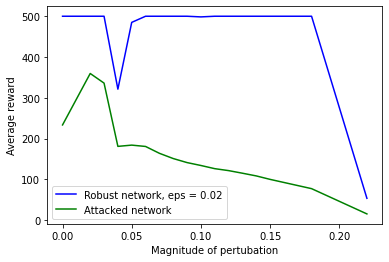

In [24]:
plt.figure(1)
plt.plot(epsilons_attacks,robust_average_rewards[0], "-b",label = "Robust network, eps = 0.02")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

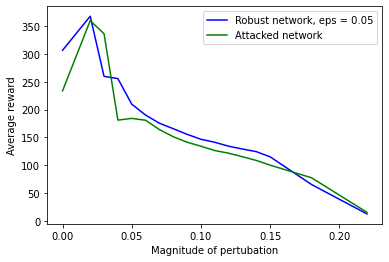

In [25]:
plt.figure(2)
plt.plot(epsilons_attacks,robust_average_rewards[1], "-b",label = "Robust network, eps = 0.05")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

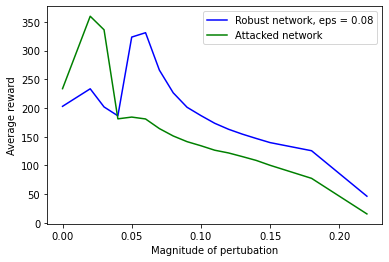

In [26]:
plt.figure(3)
plt.plot(epsilons_attacks,robust_average_rewards[2], "-b",label = "Robust network, eps = 0.08")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

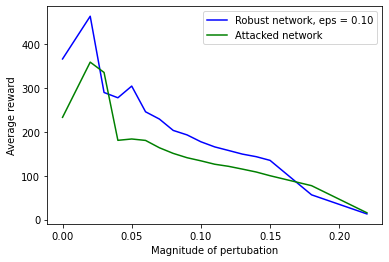

In [27]:
plt.figure(4)
plt.plot(epsilons_attacks,robust_average_rewards[3], "-b",label = "Robust network, eps = 0.10")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

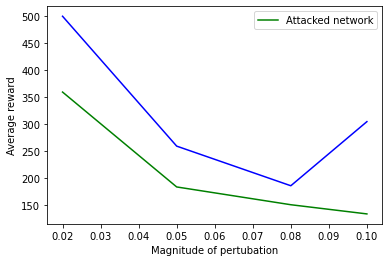

In [52]:
plt.figure(5)
average_reward_per_trained_model = [robust_average_rewards[0][1],robust_average_rewards[1][2],robust_average_rewards[2][3],robust_average_rewards[3][4]]
average_to_compare = [average_reward_number_attacked[1],average_reward_number_attacked[4],average_reward_number_attacked[7],average_reward_number_attacked[9]]
plt.plot([0.02,0.05,0.08,0.10],average_reward_per_trained_model, "-b")
plt.plot([0.02,0.05,0.08,0.10],average_to_compare, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

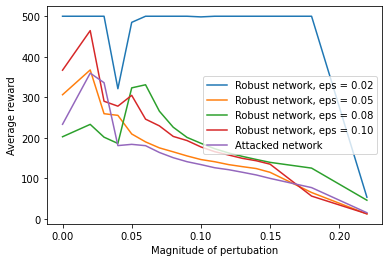

In [49]:
plt.figure(4)
plt.plot(epsilons_attacks,robust_average_rewards[0],label = "Robust network, eps = 0.02")
plt.plot(epsilons_attacks,robust_average_rewards[1],label = "Robust network, eps = 0.05")
plt.plot(epsilons_attacks,robust_average_rewards[2],label = "Robust network, eps = 0.08")
plt.plot(epsilons_attacks,robust_average_rewards[3],label = "Robust network, eps = 0.10")
plt.plot(epsilons_attacks,average_reward_number_attacked,label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()